<a href="https://colab.research.google.com/github/AudeAymone/PassengersNumberPrediction/blob/main/FinalNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Objectif du projet**

Développer et comparer plusieurs modèles de machine learning (ML) et deep learning (DL) pour prédire le nombre quotidien de passagers sur le réseau de transport Donostia San Sebastian, à partir de données historiques enrichies.

**Méthodologie**

- **Etude exploratoire**
- **Prétraitement** : encodage des variables catégorielles (target encoding, one-hot), création de features temporelles et statistiques (moyennes, écarts types, décalages).
- **Modèles testés**:
  - ML : XGBoost, LightGBM, Random Forest
  - DL : LSTM, MLP
- **Évaluation** : MAE, RMSE, R², MAPE sur les jeux d'entraînement et de test
- **Visualisation** : courbes comparatives entre trafic réel et prédiction


# Import des librairies

In [ ]:
# !pip install numpy pandas matplotlib seaborn scikit-learn tensorflow

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error

import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Load and inspect data

In [ ]:
# Charger les données
df = pd.read_csv("data_passagers.csv")

In [ ]:
print(df.shape)

(37621, 5)


Ce jeu de données contient 37621 lignes et 5 colonnes.

In [ ]:
# Afficher la description générale des données
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37621 entries, 0 to 37620
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   dateTime          37621 non-null  object
 1   weather           37621 non-null  int64 
 2   lineNumber        37621 non-null  int64 
 3   passengersNumber  37621 non-null  int64 
 4   lineType          37621 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.4+ MB
None


Nous avons au total 37621 lignes de données.
Les attributs de ce jeu de données sont:


*   dateTime
*   weather
*   lineNumber
*   passengersNumber
*   lineType



In [ ]:
# Afficher les 5 premières lignes des données
display(df.head())

,dateTime,weather,lineNumber,passengersNumber,lineType
0,2019-04-05,26,29,3032,daily
1,2019-04-05,26,42,418,daily
2,2019-04-05,26,40,2065,daily
3,2019-04-05,26,104,115,night
4,2019-04-05,26,27,2900,daily


In [ ]:
# Afficher les statistiques descriptives des données
display(df.describe())

,weather,lineNumber,passengersNumber
count,37621.000000,37621.000000,37621.000000
mean,24.010579,31.744903,2067.940990
std,11.734847,23.335248,2494.733418
min,11.000000,5.000000,1.000000
25%,13.000000,17.000000,365.000000
50%,24.000000,28.000000,1241.000000
75%,26.000000,38.000000,2558.000000
max,62.000000,110.000000,16124.000000


In [ ]:
print(df['lineNumber'].nunique())

39


Il y a **39 lignes de bus**.

# Y'a-t-il des valeurs manquantes ?

In [ ]:
import matplotlib.pyplot as plt

Nombre de valeurs manquantes par colonne :

dateTime            0
weather             0
lineNumber          0
passengersNumber    0
lineType            0
dtype: int64

Pourcentage de valeurs manquantes par colonne :

dateTime            0.0
weather             0.0
lineNumber          0.0
passengersNumber    0.0
lineType            0.0
dtype: float64


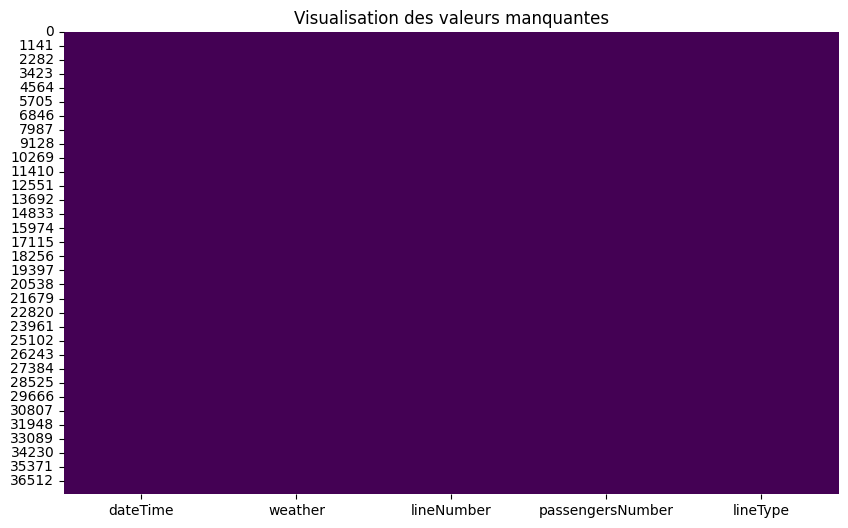

In [ ]:
import pandas as pd

# Aperçu du nombre de valeurs manquantes par colonne
missing_values = df.isnull().sum()

print("Nombre de valeurs manquantes par colonne :\n")
print(missing_values)

# Pourcentage de valeurs manquantes par colonne
missing_percentage = (df.isnull().sum() / len(df)) * 100

print("\nPourcentage de valeurs manquantes par colonne :\n")
print(missing_percentage)

# Visualisation rapide avec un heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Visualisation des valeurs manquantes")
plt.show()

Il n'y a aucune valeur manquante dans ce dataset.

# Y'a t-il des duplicats

In [ ]:
df.duplicated().sum()

np.int64(0)

Le dataset ne présente aucun duplicat.

# Data Visualisation

## Saisonnalité en fonction des périodes

### Visualisation de la saisonnalité globale

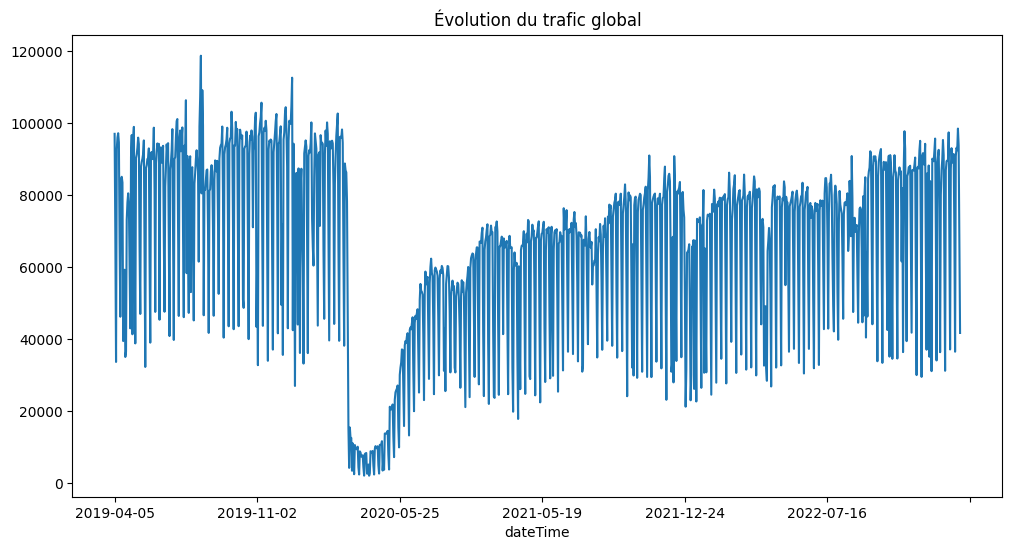

In [ ]:
# Visualisation de la saisonnalité globale
df.groupby('dateTime')['passengersNumber'].sum().plot(figsize=(12,6))
plt.title("Évolution du trafic global")
plt.show()

On constate des gap.

La cause est probablement un manque de dates dans le dataset.

Le pic descendant quant à lui correspond à la période de covid.

### Exploration des dates manquantes

In [ ]:
# Création de la plage de dates complète (du début à la fin de ton dataset)
full_range = pd.date_range(start=df['dateTime'].min(), end=df['dateTime'].max(), freq='D')

# Identification les dates qui ne sont pas dans ton DataFrame
# Transformation les dates du DF en set pour une comparaison rapide
existing_dates = pd.to_datetime(df['dateTime']).dt.normalize().unique()
missing_dates = full_range[~full_range.isin(existing_dates)]

print(f"Nombre de jours totalement absents du dataset : {len(missing_dates)}")
print("Exemples de dates manquantes :")
print(missing_dates[:10])

Nombre de jours totalement absents du dataset : 258
Exemples de dates manquantes :
DatetimeIndex(['2019-04-09', '2019-06-08', '2019-06-09', '2019-06-10', '2019-06-11', '2019-06-12', '2019-06-13', '2019-06-14', '2019-06-15', '2019-07-05'], dtype='datetime64[ns]', freq=None)


In [ ]:
missing_df = pd.DataFrame(missing_dates, columns=['date'])
missing_df['year_month'] = missing_df['date'].dt.to_period('M')

# Nombre de jours manquent par mois
missing_counts = missing_df.groupby('year_month').size()
print("Nombre de jours manquants par mois :")
print(missing_counts[missing_counts > 0])

Nombre de jours manquants par mois :
year_month
2019-04     1
2019-06     8
2019-07     1
2019-10     1
2020-01     3
2020-02     2
2020-07     5
2020-09     2
2020-10     1
2020-11    14
2020-12    31
2021-01    31
2021-02    28
2021-03    31
2021-04    16
2021-06    17
2021-08     1
2021-10     1
2022-05     3
2022-07     1
2022-09     1
2022-10     1
2022-12    12
2023-01    31
2023-02    15
Freq: M, dtype: int64


### Saisonnalité par année

In [ ]:
# Transformation de la date à bonne structuration
df['dateTime'] = pd.to_datetime(df['dateTime'], format='%Y-%m-%d')
df['day_of_week'] = df['dateTime'].dt.day_name()
df['month'] = df['dateTime'].dt.month
df['year'] = df['dateTime'].dt.year

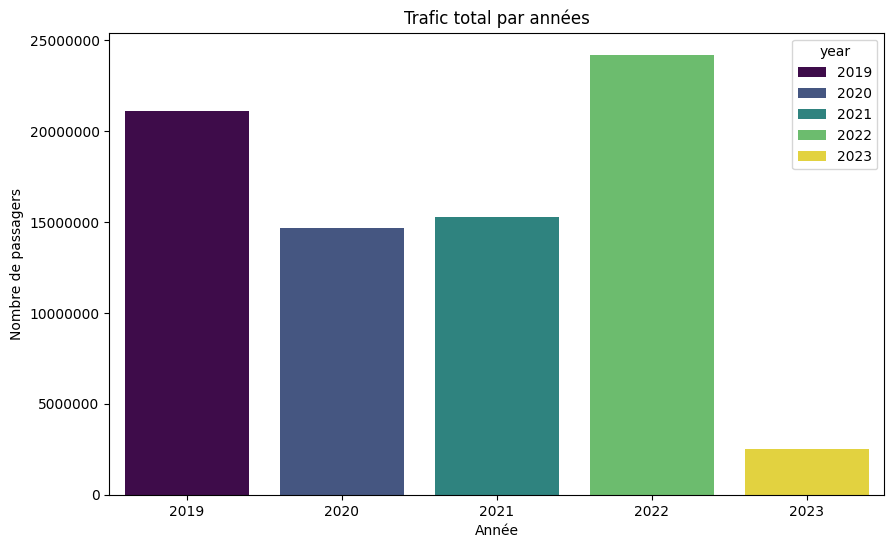

In [ ]:
df_year_traffic = df.groupby('year')['passengersNumber'].sum()

# Ordonner les années dans l'ordre croissant
df_year_traffic = df_year_traffic.sort_index()


# Créer le graphique à barres
plt.figure(figsize=(10, 6))
sns.barplot(x=df_year_traffic.index, y=df_year_traffic.values, palette='viridis', hue= df_year_traffic.index)
plt.ticklabel_format(style='plain', axis='y')
plt.title("Trafic total par années")
plt.xlabel("Année")
plt.ylabel("Nombre de passagers")
plt.show()

* On remarque une **baisse de fréquentation** pour les années **2020** et **2021**. Cela est sûrement dû au covid et aux données manquantes. Il faudrait une analyse plus approfondie de ces données.
* Le taux de fréquentation pour l'année **2023** est le plus faible car les données pour cette année ne vont qu'au mois de **Mars** et certaines dates sont manquantes.

### Saisonnalité par mois

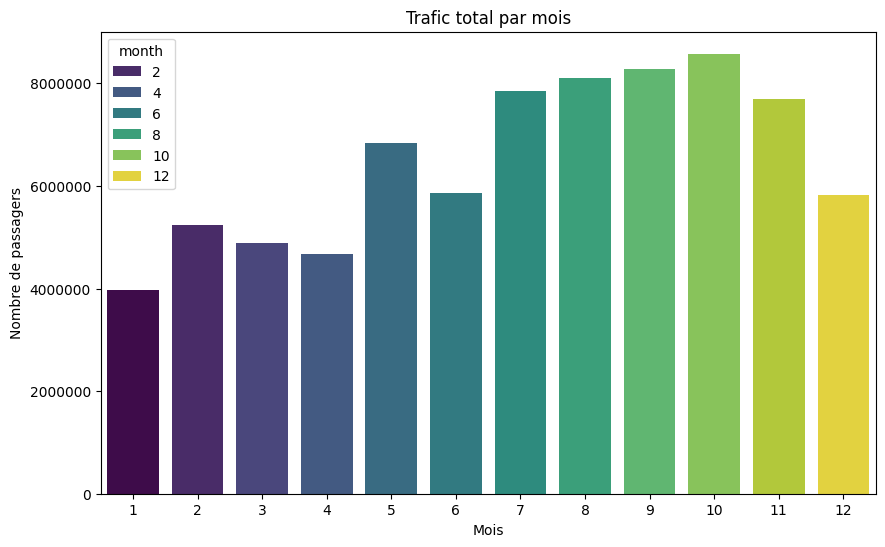

In [ ]:
df_month_traffic = df.groupby('month')['passengersNumber'].sum()

# Ordonner les années dans l'ordre croissant
df_month_traffic = df_month_traffic.sort_index()
df_month = df['month'].nunique()
# Créer le graphique à barres
plt.figure(figsize=(10, 6))
sns.barplot(x=df_month_traffic.index, y=df_month_traffic.values, palette='viridis', hue= df_month_traffic.index)
plt.ticklabel_format(style='plain', axis='y')
plt.title("Trafic total par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre de passagers")
plt.show()

- On observe une croissance constante du trafic de janvier à Avril, avec une montée en Mai (peut être du à la fin de l'hiver). ensuite une hausse de juillet à octobre avec un pic marqué en octobre (plus de 8 millions de passagers cumulés).

- Le mois d'août est élevé (tourisme + Semana Grande), mais la rentrée d'octobre est encore plus forte. Le creux de décembre/janvier correspond aux vacances de fin d'année.

### Saisonnalité par semaine

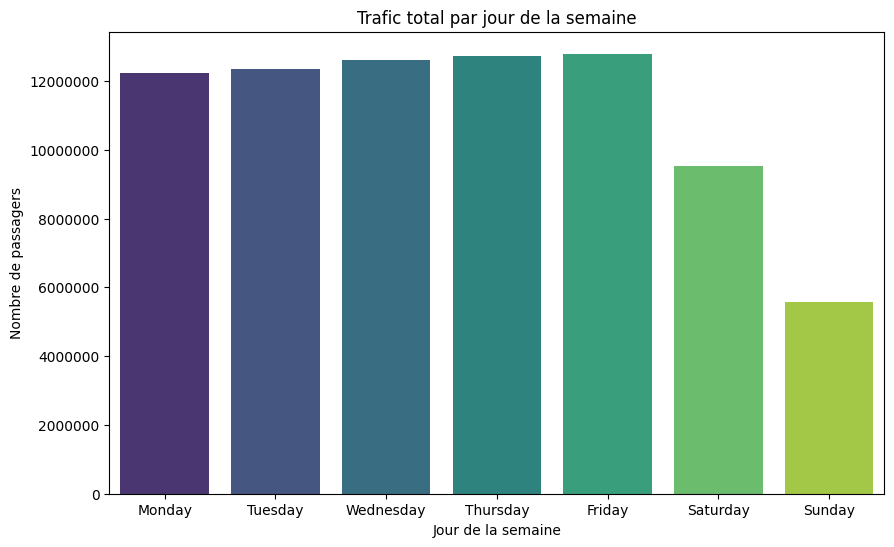

In [ ]:
df_daily_traffic = df.groupby('day_of_week')['passengersNumber'].sum()

# Ordonner les jours de la semaine pour une meilleure visualisation
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_daily_traffic = df_daily_traffic.reindex(day_order)

# Créer le graphique à barres
plt.figure(figsize=(10, 6))
sns.barplot(x=df_daily_traffic.index, y=df_daily_traffic.values, palette='viridis',hue= day_order)
plt.ticklabel_format(style='plain', axis='y')
plt.title("Trafic total par jour de la semaine")
plt.xlabel("Jour de la semaine")
plt.ylabel("Nombre de passagers")
plt.show()

* Nous remarquons une certaine **saisonnalité** avec **une baisse de fréquentation** durant **les weekends**.
Cela est du au fait que les week-ends sont des jours non ouvrables.

## Distribution des passagers par type de ligne

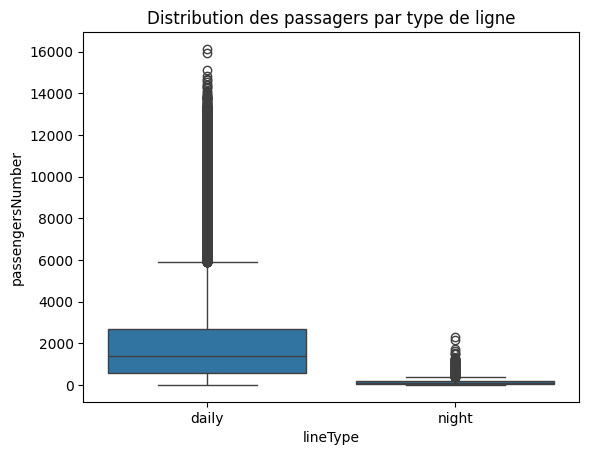

In [ ]:
# Visualisation de la distribution des passagers par type de ligne (Dayline vs Nightline)
sns.boxplot(x='lineType', y='passengersNumber', data=df)
plt.title("Distribution des passagers par type de ligne")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

Les lignes de bus de **jour** sont beaucoup plus fréquentées que celles de **nuit**.

## Distribution des lignes par type

### Distribution des lignes par type

/tmp/ipython-input-3379430066.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=line_distribution, x='lineType', y='nb_lignes', palette='viridis')


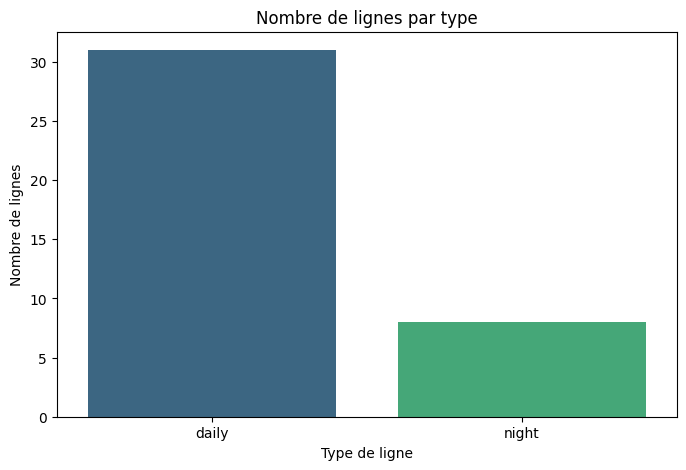

In [ ]:
# Groupby lineType et compter le nombre de lignes
line_distribution = df.groupby('lineType')['lineNumber'].nunique().reset_index()

# Renommer les colonnes pour plus de clarté
line_distribution.columns = ['lineType', 'nb_lignes']

# Visualisation de la distribution des lignes par type
plt.figure(figsize=(8,5))
sns.barplot(data=line_distribution, x='lineType', y='nb_lignes', palette='viridis')

plt.title("Nombre de lignes par type")
plt.xlabel("Type de ligne")
plt.ylabel("Nombre de lignes")
plt.show()

Il y a au 31 lignes de jour et 8 de nuit.

### Trafic pour les lignes de jour

/tmp/ipython-input-736284322.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=daily_shift, x='lineNumber', y='passengersNumber', palette='magma')


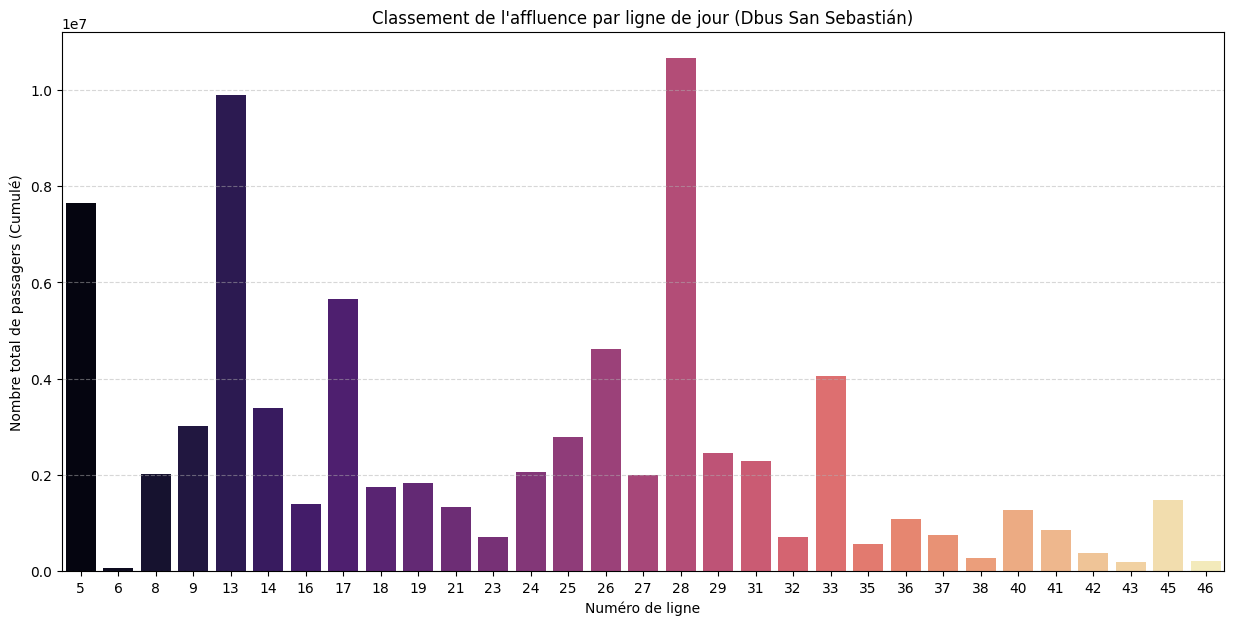

In [ ]:
# Filtrer uniquement les lignes de nuit
df_day = df[df['lineType'] == 'daily']

# 2. Grouper par ligne pour obtenir l'affluence totale
# On utilise la somme pour voir quelles lignes transportent le plus de monde
daily_shift = df_day.groupby('lineNumber')['passengersNumber'].sum().reset_index()

# 4. Visualisation
plt.figure(figsize=(15, 7)) # On élargit car il y a beaucoup de lignes
sns.barplot(data=daily_shift, x='lineNumber', y='passengersNumber', palette='magma')

plt.title("Classement de l'affluence par ligne de jour (Dbus San Sebastián)")
plt.xlabel("Numéro de ligne")
plt.ylabel("Nombre total de passagers (Cumulé)")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

Les lignes 28 et 13 sont les plus fréquentées. La 6 est la moins fréquentée.
- Ligne 28 (Amara - Ospitaleak) : C'est la ligne la plus fréquentée, dépassant les 10 millions de passagers. Sa position dominante s'explique par le fait qu'elle dessert le quartier très dense d'Amara et le complexe hospitalier, le principal pôle de santé de la province.

- Ligne 13 (Altza) : Avec près de 10 millions de passagers, c'est la deuxième ligne majeure. Elle relie le centre-ville au quartier d'Altza, l'un des plus peuplés et éloignés du centre.

les lignes 5, 17, 26 et 33 demeurrent significatives
- Ligne 5 (Benta Berri) : Très fréquentée car elle dessert le quartier universitaire et le quartier d'Antiguo.

- Ligne 17 (Gros - Amara - Miramon) : Une ligne transversale importante.

- Ligne 26 (Amara - Martutene) : Un axe sud essentiel.

- Ligne 33 (Larratxo - Intxaurrondo - Antiguo - Berio) : Une ligne "ceinture" qui connecte les quartiers entre eux sans passer forcément par l'hyper-centre.

les autres lignes representent:
- Les lignes de proximité (microbus) ou de lignes desservant des zones de faible densité (collines comme Igeldo ou Ulia).
La ligne 6, par exemple, est historiquement une ligne avec peu de fréquentation comparée aux grands axes radiaux car c'est une ligne microbus qui fonctionnent uniquement sous réservation.

### Trafic pour les lignes de nuit

/tmp/ipython-input-2425584046.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=night_shift, x='lineNumber', y='passengersNumber', palette='viridis')


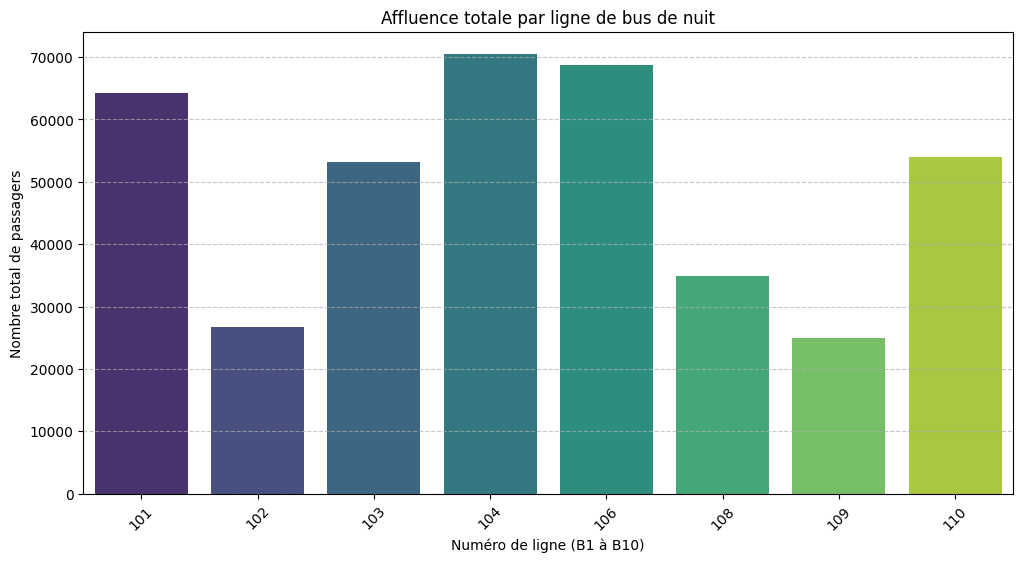

In [ ]:
# Filtrer uniquement les lignes de nuit
df_night = df[df['lineType'] == 'night']

night_shift = df_night.groupby('lineNumber')['passengersNumber'].sum().reset_index()

# 3. Visualisation
plt.figure(figsize=(12, 6))
sns.barplot(data=night_shift, x='lineNumber', y='passengersNumber', palette='viridis')

plt.title("Affluence totale par ligne de bus de nuit")
plt.xlabel("Numéro de ligne (B1 à B10)")
plt.ylabel("Nombre total de passagers")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- On retrouve la même logique que sur le premier graphique : les quartiers d'Altza 106 (B6) et d'Amara 104 (B4) restent les moteurs principaux du transport public, que ce soit à 14h ou à 4h du matin.

## Trafic par numéro de ligne

/tmp/ipython-input-864624363.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lines.index, y=lines.values, palette="viridis")


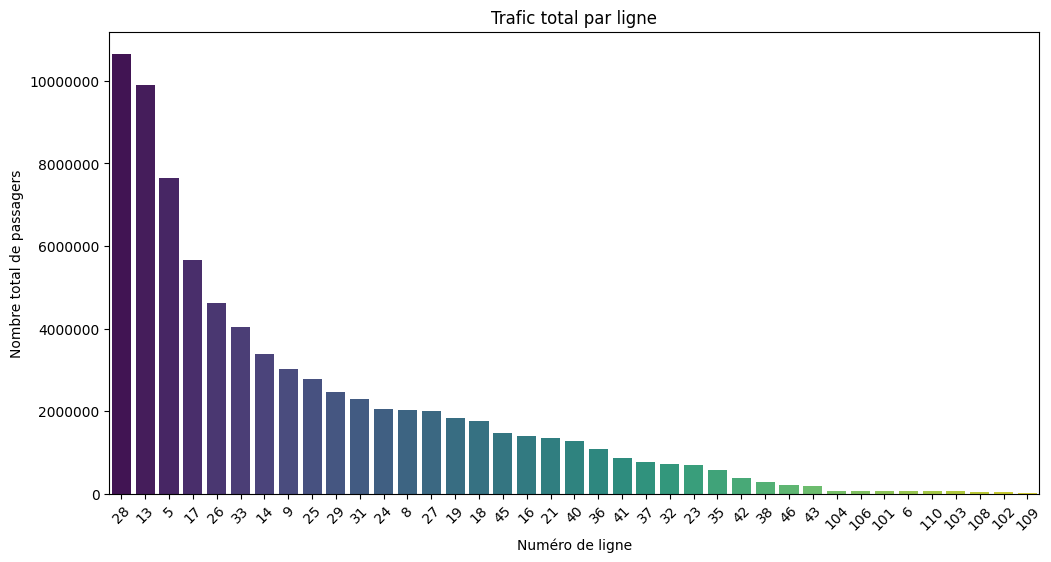

In [ ]:
df_line_traffic = df.groupby('lineNumber')['passengersNumber'].sum()

# Tri décroissant et sélection du top 20
lines = df_line_traffic.sort_values(ascending=False)

# Conversion en string pour éviter l'ordre numérique
lines.index = lines.index.astype(str)

# Visualisation
plt.figure(figsize=(12, 6))
sns.barplot(x=lines.index, y=lines.values, palette="viridis")

plt.ticklabel_format(style='plain', axis='y')
plt.title("Trafic total par ligne")
plt.xlabel("Numéro de ligne")
plt.ylabel("Nombre total de passagers")
plt.xticks(rotation=45)
plt.show()


- Comme on l'a dit plus haut les lignes 28 et 13 representent le coeur du réseau urbain de san sebastian. elles sont suivis par d'autres lignes structurantes tels que la 5, 17, 26 et la 33. Quant aux autres on est sois sur des lignes spéciales (la 6) des lignes qui desservent des zones peu peuplées ainsi que les lignes de nuit.

## Top 20 des lignes les plus fréquentés

/tmp/ipython-input-3928950261.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top20_lines.index, y=top20_lines.values, palette="viridis")


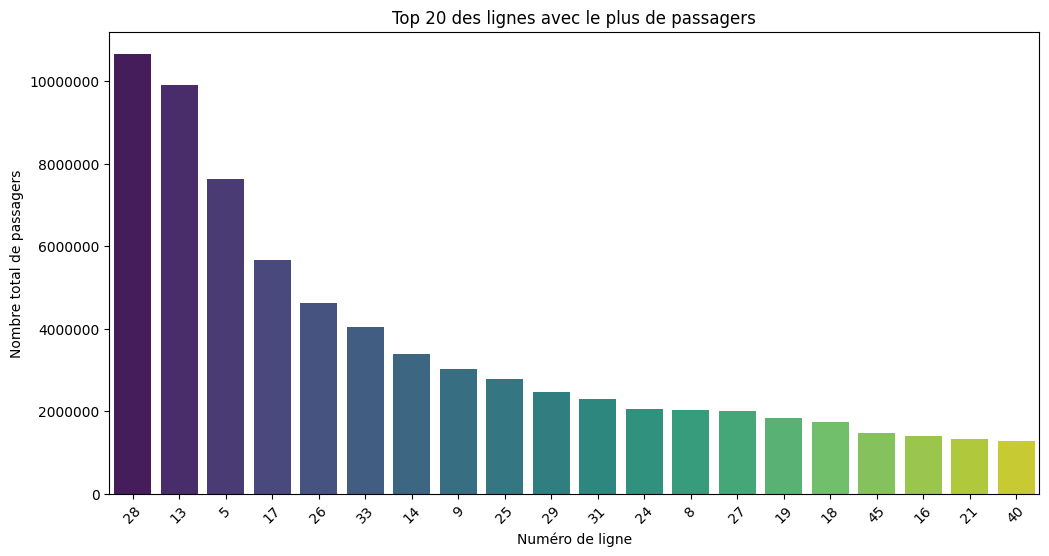

In [ ]:
df_line_traffic = df.groupby('lineNumber')['passengersNumber'].sum()

# Tri décroissant et sélection du top 20
top20_lines = df_line_traffic.sort_values(ascending=False).head(20)

# Conversion en string pour éviter l'ordre numérique
top20_lines.index = top20_lines.index.astype(str)

# Visualisation
plt.figure(figsize=(12, 6))
sns.barplot(x=top20_lines.index, y=top20_lines.values, palette="viridis")

plt.ticklabel_format(style='plain', axis='y')
plt.title("Top 20 des lignes avec le plus de passagers")
plt.xlabel("Numéro de ligne")
plt.ylabel("Nombre total de passagers")
plt.xticks(rotation=45)
plt.show()


## Corrélation des variables

#### Visualisation de toutes les variables

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
print(df.head())

    dateTime  weather  lineNumber  passengersNumber lineType day_of_week  month  year
0 2019-04-05       26          29              3032    daily      Friday      4  2019
1 2019-04-05       26          42               418    daily      Friday      4  2019
2 2019-04-05       26          40              2065    daily      Friday      4  2019
3 2019-04-05       26         104               115    night      Friday      4  2019
4 2019-04-05       26          27              2900    daily      Friday      4  2019


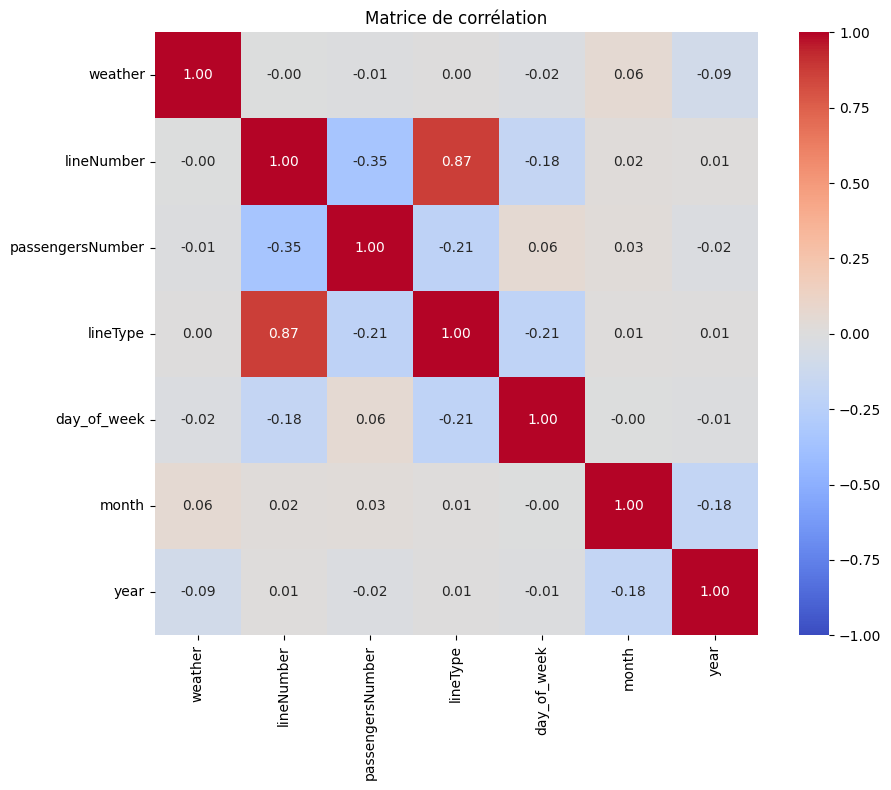

In [ ]:
# Matrice de corrélation par rapport à la target passengersNumber

# Préparer une copie pour ne pas modifier le df original
df_corr = df.copy()

for col in ['date', 'dateTime', 'year_month']:
    if col in df_corr.columns:
        df_corr = df_corr.drop(columns=[col])

# Encoder les variables catégorielles en codes numériques pour la corrélation
for col in ['lineType', 'day_of_week']:
    if col in df_corr.columns:
        df_corr[col] = df_corr[col].astype('category').cat.codes

# Calculer la matrice de corrélation
corr_matrix = df_corr.corr()


# Afficher la heatmap des corrélations (incluant la target)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Matrice de corrélation")
plt.tight_layout()
plt.show()

* **lineNumber** Corrélation négative modérée : certaines lignes de bus ont moins de passagers que d’autres. Le numéro de ligne est donc un facteur discriminant.
* **lineType** Corrélation négative faible à modérée : le type de ligne (ex. urbaine vs interurbaine) influence le nombre de passagers.

- Les variables lineNumber et lineType sont les plus explicatives (elles différencient les lignes en termes d’affluence).
- Les variables temporelles simples (day_of_week, month, year) n’expliquent pas beaucoup à elles seules.
- La météo telle que codée actuellement n’apporte pas d’information (il faudrait peut-être la transformer en catégories plus pertinentes).


**Il n'y a pas de corrélation linéaire forte entre les features actuelles et la variable cible**.

## Feature engineering

### Encodage de day_of_week, is_weekend

In [ ]:
df['day_of_week_num'] = df['dateTime'].dt.dayofweek
df['is_weekend'] = df['day_of_week_num'].isin([5,6]).astype(int)

In [ ]:
print(df.sample(10))

        dateTime  weather  lineNumber  passengersNumber lineType day_of_week  month  year  day_of_week_num  is_weekend
21584 2021-09-14       25          46               265    daily     Tuesday      9  2021                1           0
3748  2019-08-06       45          41               862    daily     Tuesday      8  2019                1           0
593   2019-04-23       26          14              3236    daily     Tuesday      4  2019                1           0
37259 2023-03-09       23           5              8447    daily    Thursday      3  2023                3           0
18010 2021-05-07       13          42               335    daily      Friday      5  2021                4           0
24474 2021-12-11       26           9              2479    daily    Saturday     12  2021                5           1
17404 2021-04-17       43          29              1784    daily    Saturday      4  2021                5           1
24036 2021-11-29       26          32           

### Encodage de lineNumber

In [ ]:
df['lineNumber'] = df['lineNumber'].astype('category')

### Encodage des variables catégorielles (weather, lineType)


#### Encodage de weather

In [ ]:
weather_mapping = {
    # Famille 1: très pluvieux
    25: 1, 53: 1, 54: 1, 52: 1, 61: 1, 62: 1,
    # Famille 2: pluvieux
    12: 2, 24: 2, 26: 2, 45: 2, 46: 2, 51: 2,
    # Famille 3: Très nuageux
    13: 3, 14: 3, 15: 3, 16: 3, 23: 3, 35: 3, 43: 3,
    # Famille 4 : Partiellement nuageux
    17: 4, 44: 4,
    # Famille 5: Ensoleillé
    11: 5
}

df['weather_family'] = df['weather'].map(weather_mapping)

df = pd.get_dummies(df, columns=['weather_family'], prefix='weather_family')

In [ ]:
display(df.sample(10))

,dateTime,weather,lineNumber,passengersNumber,lineType,day_of_week,month,year,day_of_week_num,is_weekend,weather_family_1,weather_family_2,weather_family_3,weather_family_4,weather_family_5
27297,2022-03-08,25,35,827,daily,Tuesday,3,2022,1,0,True,False,False,False,False
32391,2022-08-14,25,8,1849,daily,Sunday,8,2022,6,1,True,False,False,False,False
4528,2019-08-29,13,38,296,daily,Thursday,8,2019,3,0,False,False,True,False,False
16051,2020-10-04,54,38,127,daily,Sunday,10,2020,6,1,True,False,False,False,False
24186,2021-12-03,26,106,67,night,Friday,12,2021,4,0,False,True,False,False,False
4961,2019-09-11,43,42,438,daily,Wednesday,9,2019,2,0,False,False,True,False,False
30969,2022-06-30,25,35,717,daily,Thursday,6,2022,3,0,True,False,False,False,False
19108,2021-06-29,45,43,211,daily,Tuesday,6,2021,1,0,False,True,False,False,False
26283,2022-02-05,24,41,547,daily,Saturday,2,2022,5,1,False,True,False,False,False
26922,2022-02-25,23,28,10519,daily,Friday,2,2022,4,0,False,False,True,False,False


In [ ]:
# Supprimer weather non encodé
df = df.drop(columns=['weather'])
print(df.columns)

Index(['dateTime', 'lineNumber', 'passengersNumber', 'lineType', 'day_of_week', 'month', 'year', 'day_of_week_num', 'is_weekend', 'weather_family_1', 'weather_family_2', 'weather_family_3', 'weather_family_4', 'weather_family_5'], dtype='object')


#### Encodage de lineType

In [ ]:
df['lineType'] = df['lineType'].astype('category').cat.codes

In [ ]:
display(df.sample(10))

,dateTime,lineNumber,passengersNumber,lineType,day_of_week,month,year,day_of_week_num,is_weekend,weather_family_1,weather_family_2,weather_family_3,weather_family_4,weather_family_5
13958,2020-07-30,5,5571,0,Thursday,7,2020,3,0,False,True,False,False,False
33308,2022-09-11,46,170,0,Sunday,9,2022,6,1,False,False,False,False,True
16228,2020-10-10,29,1621,0,Saturday,10,2020,5,1,True,False,False,False,False
34495,2022-10-17,36,1194,0,Monday,10,2022,0,0,False,False,True,False,False
11739,2020-04-22,9,513,0,Wednesday,4,2020,2,0,False,True,False,False,False
20927,2021-08-25,24,1555,0,Wednesday,8,2021,2,0,False,False,True,False,False
35792,2022-11-26,36,855,0,Saturday,11,2022,5,1,False,False,False,True,False
12595,2020-06-04,33,2337,0,Thursday,6,2020,3,0,True,False,False,False,False
34929,2022-10-31,26,4813,0,Monday,10,2022,0,0,False,True,False,False,False
10953,2020-03-17,46,29,0,Tuesday,3,2020,1,0,False,True,False,False,False


### Ajout d'une variable is_holiday

In [ ]:
import holidays as hd

In [ ]:
es_holidays = hd.Spain(subdiv="PV", years=range(2019,2024))

df["is_holiday"] = df['dateTime'].isin(es_holidays).astype(int)

display(df[['is_holiday','dateTime']])

/tmp/ipython-input-915818206.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["is_holiday"] = df['dateTime'].isin(es_holidays).astype(int)


,is_holiday,dateTime
0,0,2019-04-05
1,0,2019-04-05
2,0,2019-04-05
3,0,2019-04-05
4,0,2019-04-05
...,...,...
37616,0,2023-03-19
37617,0,2023-03-19
37618,0,2023-03-19
37619,0,2023-03-19


### Ajout d'une variable is_tamborrada

In [ ]:
# Ajout de la San Sebastián Day
custom_dates = ['2023-01-20', '2022-01-20','2021-01-20','2020-01-20','2019-01-20']
df['is_tamborrada'] = df['dateTime'].dt.strftime('%Y-%m-%d').isin(custom_dates).astype(int)

display(df[['is_tamborrada','dateTime']])

,is_tamborrada,dateTime
0,0,2019-04-05
1,0,2019-04-05
2,0,2019-04-05
3,0,2019-04-05
4,0,2019-04-05
...,...,...
37616,0,2023-03-19
37617,0,2023-03-19
37618,0,2023-03-19
37619,0,2023-03-19


In [ ]:
total_tamborrada = df[df['is_tamborrada'] == 1].groupby('dateTime')['passengersNumber'].sum().reset_index()

print("Trafic total cumulé (toutes lignes) pour la Tamborrada :")
display(total_tamborrada)

Trafic total cumulé (toutes lignes) pour la Tamborrada :


,dateTime,passengersNumber
0,2020-01-20,60445
1,2022-01-20,30644


### Ajout d'une variable is_semana_grande

La semana grande est une semaine festivependant le mois d'août qui enregistre en général de grandes affluences.

In [ ]:
semana_grande_dates = {
    2019: ('2019-08-10', '2019-08-17'),
    2020: (None, None), # Annulée à cause du COVID
    2021: (None, None), # Annulée à cause du COVID
    2022: ('2022-08-13', '2022-08-20'),
    2023: ('2023-08-12', '2023-08-19')
}

def is_semana_grande(dt):
    year = dt.year
    if year not in semana_grande_dates:
        return 0
    start, end = semana_grande_dates[year]
    if start and end:
        if pd.to_datetime(start) <= dt <= pd.to_datetime(end):
            return 1
    return 0


# Application sur ton DataFrame complet (57 000 lignes)
df['is_semana_grande'] = df['dateTime'].apply(is_semana_grande)

### Ajout d'une variable is_match_day

La ville de San Sebastian se caractérise par son amour pour le foot notamment grace à son célèbre club de foot la Real Sociedad. Les jours de  match à domicile pourraient donc permettre au modèle de réaliser de meilleures prédictions.

In [ ]:
match_day = ['2019-04-14', '2019-04-25', '2019-04-28',
'2019-05-12', '2021-08-22','2021-08-28','2021-09-19','2021-09-26','2021-09-30','2021-10-16','2021-10-31','2021-11-04','2021-11-21','2021-12-04',
'2021-12-09','2021-12-18','2022-01-08','2022-01-19','2022-01-23','2022-02-03','2022-02-13','2022-02-24','2022-02-27','2022-03-13','2022-04-04',
'2022-04-15','2022-04-21','2022-05-12','2022-05-22','2022-08-21','2022-09-08','2022-09-15','2022-09-18','2022-10-09','2022-10-13','2022-10-19',
'2022-10-30','2022-11-03','2022-11-06','2022-12-31','2023-01-14','2023-01-17','2023-02-05','2023-02-18','2023-03-03','2023-03-16','2023-03-19']

df['is_match_day'] = df['dateTime'].dt.strftime("%Y-%m-%d").isin(match_day).astype(int)

### Lag features (Captation des dépendances aux jours précédents)

#### Captation sur 3 jours d'affilé

In [ ]:
df = df.sort_values(by=['lineNumber','dateTime'])
df['passengersNumber_of_yesterday'] = df.groupby('lineNumber')['passengersNumber'].shift(1)
df['passengersNumber_of_two_days_ago'] = df.groupby('lineNumber')['passengersNumber'].shift(2)
df['passengersNumber_of_three_days_ago'] = df.groupby('lineNumber')['passengersNumber'].shift(3)

/tmp/ipython-input-2170935874.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['passengersNumber_of_yesterday'] = df.groupby('lineNumber')['passengersNumber'].shift(1)
/tmp/ipython-input-2170935874.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['passengersNumber_of_two_days_ago'] = df.groupby('lineNumber')['passengersNumber'].shift(2)
/tmp/ipython-input-2170935874.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this wa

#### Captation sur 7 jours et 14 jours

In [ ]:
# Trafic à la même heure/jour la semaine dernière
df['passengers_J_minus_7'] = df.groupby('lineNumber')['passengersNumber'].shift(7)
# Trafic il y a 2 semaines (optionnel mais utile)
df['passengers_J_minus_14'] = df.groupby('lineNumber')['passengersNumber'].shift(14)

/tmp/ipython-input-2955224952.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['passengers_J_minus_7'] = df.groupby('lineNumber')['passengersNumber'].shift(7)
/tmp/ipython-input-2955224952.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['passengers_J_minus_14'] = df.groupby('lineNumber')['passengersNumber'].shift(14)


#### Captation sur 7j (Moyenne et écart-type)

In [ ]:
# Moyenne mobile sur 7 jours (rolling mean)
df['moyenne_traffic_sur_7j'] = (
    df.groupby('lineNumber')['passengersNumber']
      .shift(1)  # décalage pour ne pas inclure le jour courant
      .rolling(window=7)
      .mean()
)

# Moyenne mobile sur 7 jours (rolling mean)
df['moyenne_traffic_sur_30j'] = (
    df.groupby('lineNumber')['passengersNumber']
      .shift(1)  # décalage pour ne pas inclure le jour courant
      .rolling(window=30)
      .mean()
)

# Écart-type mobile sur 7 jours (rolling std)
df['ecart_type_traffic_sur_7j'] = (
      df.groupby('lineNumber')['passengersNumber']
        .shift(1)
        .rolling(window=7)
        .std()
  )

# Écart-type mobile sur 30 jours (rolling std)
df['ecart_type_traffic_sur_30j'] = (
    df.groupby('lineNumber')['passengersNumber']
      .shift(1)
      .rolling(window=30)
      .std()
)


/tmp/ipython-input-1103814479.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('lineNumber')['passengersNumber']
/tmp/ipython-input-1103814479.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('lineNumber')['passengersNumber']
/tmp/ipython-input-1103814479.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('lineNumber')['passengersNumber']
/tmp/ipython-input-1103814479.py:27: Futu

In [ ]:
display(df.head(10))

,dateTime,lineNumber,passengersNumber,lineType,day_of_week,month,year,day_of_week_num,is_weekend,weather_family_1,weather_family_2,weather_family_3,weather_family_4,weather_family_5,is_holiday,is_tamborrada,is_semana_grande,is_match_day,passengersNumber_of_yesterday,passengersNumber_of_two_days_ago,passengersNumber_of_three_days_ago,passengers_J_minus_7,passengers_J_minus_14,moyenne_traffic_sur_7j,moyenne_traffic_sur_30j,ecart_type_traffic_sur_7j,ecart_type_traffic_sur_30j
37,2019-04-05,5,10426,0,Friday,4,2019,4,0,False,True,False,False,False,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,2019-04-06,5,7330,0,Saturday,4,2019,5,1,True,False,False,False,False,0,0,0,0,10426.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,2019-04-07,5,3179,0,Sunday,4,2019,6,1,True,False,False,False,False,0,0,0,0,7330.0,10426.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,2019-04-08,5,9618,0,Monday,4,2019,0,0,False,True,False,False,False,0,0,0,0,3179.0,7330.0,10426.0,NaN,NaN,NaN,NaN,NaN,NaN
146,2019-04-10,5,9974,0,Wednesday,4,2019,2,0,True,False,False,False,False,0,0,0,0,9618.0,3179.0,7330.0,NaN,NaN,NaN,NaN,NaN,NaN
178,2019-04-11,5,9887,0,Thursday,4,2019,3,0,False,True,False,False,False,0,0,0,0,9974.0,9618.0,3179.0,NaN,NaN,NaN,NaN,NaN,NaN
230,2019-04-12,5,9530,0,Friday,4,2019,4,0,False,False,True,False,False,0,0,0,0,9887.0,9974.0,9618.0,NaN,NaN,NaN,NaN,NaN,NaN
243,2019-04-13,5,7275,0,Saturday,4,2019,5,1,False,True,False,False,False,0,0,0,0,9530.0,9887.0,9974.0,10426.0,NaN,8563.428571,NaN,2574.571929,NaN
289,2019-04-14,5,5395,0,Sunday,4,2019,6,1,False,False,True,False,False,0,0,0,1,7275.0,9530.0,9887.0,7330.0,NaN,8113.285714,NaN,2467.893820,NaN
319,2019-04-15,5,9050,0,Monday,4,2019,0,0,True,False,False,False,False,0,0,0,0,5395.0,7275.0,9530.0,3179.0,NaN,7836.857143,NaN,2670.319920,NaN


On constate des NaN au niveau des lags. Cela est normal, étant donné l'absence de certaines dates.

## Mesure de corrélation avec la variable cible (avec les nouvelles features)

In [ ]:
import numpy as np

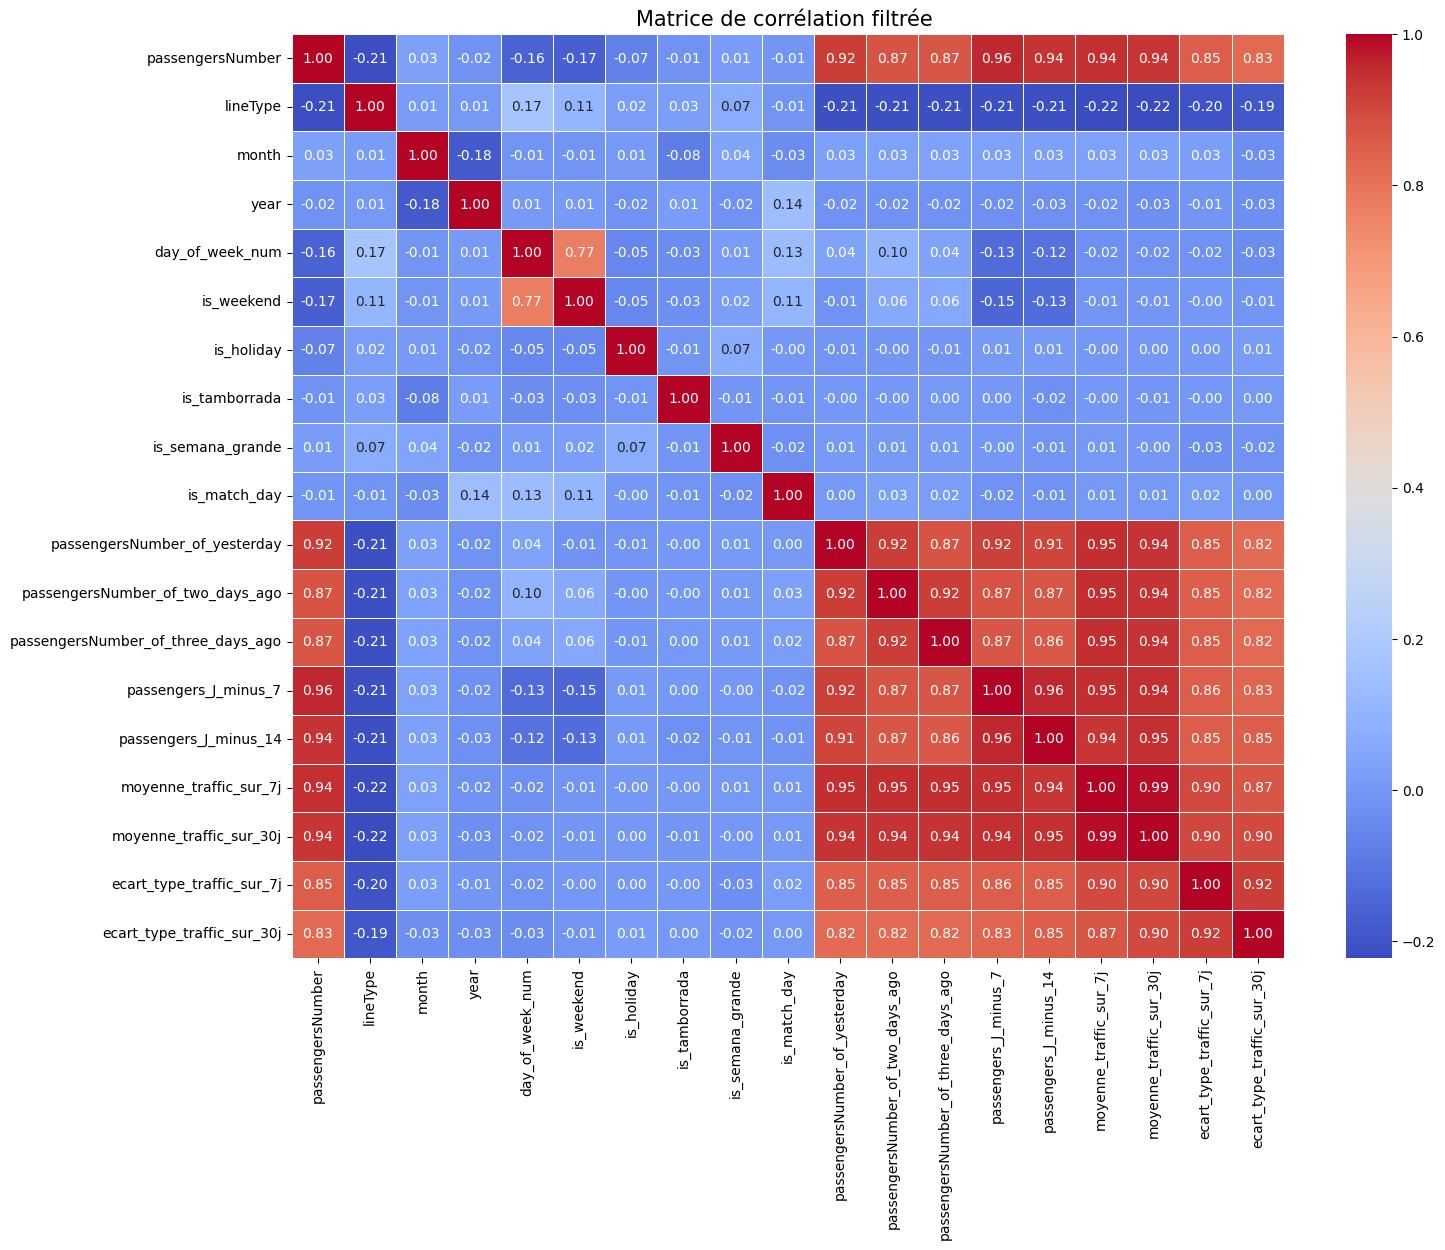

In [ ]:
  # Préparer une copie pour ne pas modifier le df original
df_corr = df.copy()


# Calcul de la nouvelle matrice de corrélation
corr_matrix = df_corr.select_dtypes(include=[np.number]).corr()

# Affichage de la matrice complète nettoyée
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Matrice de corrélation filtrée ", fontsize=15)
plt.show()

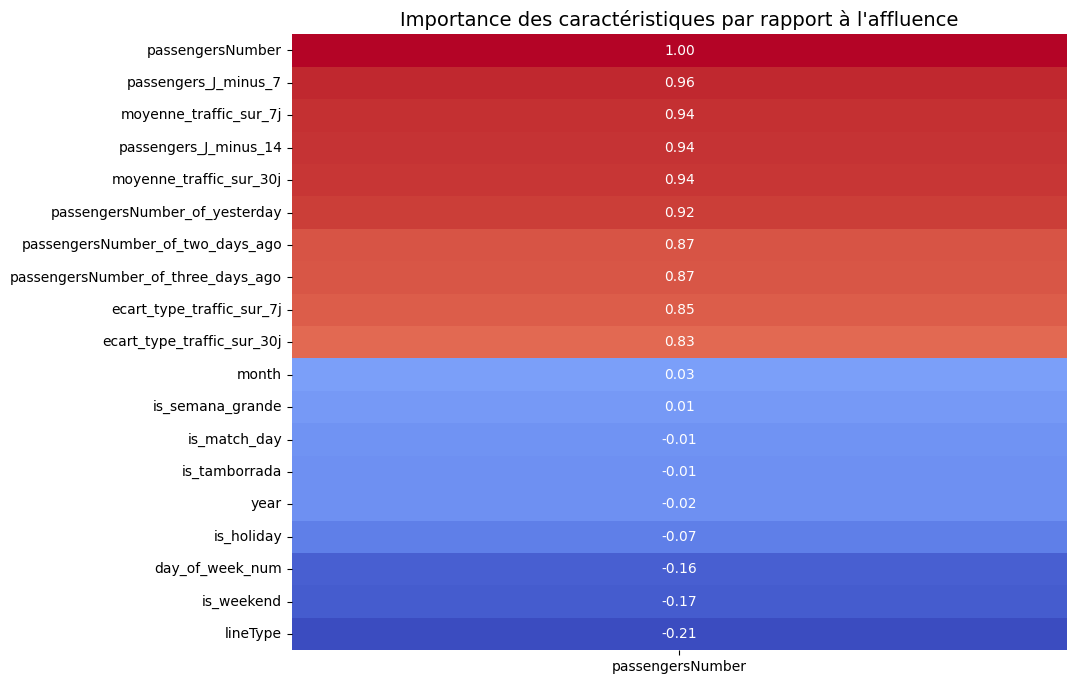

In [ ]:
# Extraction des corrélations uniquement par rapport à la variable cible
target_corr = corr_matrix['passengersNumber'].sort_values(ascending=False).to_frame()

# Création d'un graphique à barres pour une lecture immédiate
plt.figure(figsize=(10, 8))
sns.heatmap(target_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=False)
plt.title("Importance des caractéristiques par rapport à l'affluence", fontsize=14)
plt.show()

**Analyse de la corrélation des caractéristiques**


Le graphique présente la force du lien linéaire entre les différentes variables et le nombre de passagers.

* **Prédominance des données historiques** : Les variables liées au passé immédiat ou cyclique (J-7, moyennes mobiles sur 7 et 30 jours, J-1, etc.) présentent les corrélations les plus fortes, avec des coefficients supérieurs à 0,80. Cela indique une forte saisonnalité et une inertie importante du trafic.

* **Variables calendaires et catégorielles** : Le mois, l'année et les événements spécifiques (Semana Grande, jours de match) affichent une corrélation proche de zéro, suggérant que leur impact individuel sur la variation linéaire globale est faible.

* **Corrélations négatives modérées** : Le type de ligne (-0,21), le statut de week-end (-0,17) et le numéro du jour de la semaine (-0,16) présentent une corrélation négative. Cela signifie généralement que le volume de passagers tend à diminuer durant les week-ends ou sur certains types de lignes spécifiques par rapport à la moyenne.

La forte dépendance aux variables de "Lag" (données décalées dans le temps) confirme que le modèle s'appuie principalement sur l'historique récent pour effectuer les prédictions. Les variables binaires (vacances, événements) apportent une information contextuelle plus subtile qui n'est pas captée par une simple analyse de corrélation linéaire

## Split temporel pour la modélisation

Dans l'étude des séries temporelles, nous faisons l'hypothèse de stationnarité ou, à défaut, de stabilité des relations entre les variables explicatives et la cible. La période 2020-2021 à San Sebastián constitue une rupture structurelle majeure : le comportement des usagers était dicté par des contraintes externes (confinements, jauges) et non par les cycles habituels de transport.

En appliquant un fenêtrage glissant commençant en juillet 2021, on élimine le "bruit" historique lié à la crise sanitaire. Cette méthode permet au modèle XGBoost de se concentrer sur la "nouvelle normalité" (reprise du travail en présentiel, nouveaux horaires). Cela garantit que les lags (J-7, J-1) utilisés par le modèle reflètent des dynamiques de mobilité contemporaines à celles de ton set de test en 2023, optimisant ainsi la capacité de généralisation du modèle.

In [ ]:
# 1. Liste des features les plus importantes (zone rouge de la heatmap)
features = [
    'passengers_J_minus_7',
    'passengers_J_minus_14',
    'passengersNumber_of_yesterday',
    'passengersNumber_of_two_days_ago',
    'passengersNumber_of_three_days_ago',
    'moyenne_traffic_sur_7j',
    'moyenne_traffic_sur_30j',
    'ecart_type_traffic_sur_7j',
    'ecart_type_traffic_sur_30j',
    'is_weekend',
    'is_holiday',
    'is_tamborrada',
    'is_semana_grande',
]

target = 'passengersNumber'

# 2. Définition du point de départ (Post-restrictions majeures)
cut_off_date = '2021-07-01'

# 3. Copie du dataset
df_customized = df.copy()

# 4. Filtrage du dataset à partir de la date seuil
df_windowed = df_customized[df_customized['dateTime'] >= cut_off_date].copy()

In [ ]:

# On ne garde que les données à partir de juillet 2021
df_windowed = df_customized[df_customized['dateTime'] >= cut_off_date].copy()

# 4. Séparation Train / Test
# Train : Juillet 2021 -> 31 Décembre 2022
# Test  : 1er Janvier 2023 -> Fin
train_mask = (df_windowed['dateTime'] < '2023-02-01')
test_mask = (df_windowed['dateTime'] >= '2023-02-01')

df_train = df_windowed[train_mask]
df_test = df_windowed[test_mask]

# 4. Préparation des matrices pour XGBoost
X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

print(f"Période d'entraînement : {df_train['dateTime'].min()} au {df_train['dateTime'].max()}")
print(f"Nombre de lignes pour l'entraînement : {len(df_train)}")

Période d'entraînement : 2021-07-01 00:00:00 au 2022-12-19 00:00:00
Nombre de lignes pour l'entraînement : 17403


# Modelisation

### Baseline: XGBoost

#### Import de librairies

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


#### Entraîner un modèle XGBoost baseline

In [ ]:
model = xgb.XGBRegressor(
    tree_method="hist",
    enable_categorical=True,
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

[0]	validation_0-rmse:2659.42557
[100]	validation_0-rmse:428.44761
[200]	validation_0-rmse:409.86472
[300]	validation_0-rmse:400.12065
[400]	validation_0-rmse:395.15868
[500]	validation_0-rmse:392.30137
[600]	validation_0-rmse:390.93359
[700]	validation_0-rmse:390.02205
[800]	validation_0-rmse:389.99591
[803]	validation_0-rmse:389.95574


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

<Figure size 1000x800 with 0 Axes>

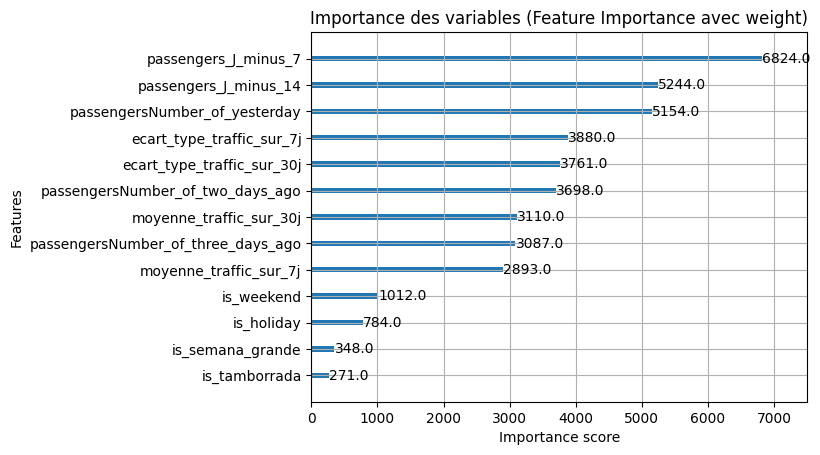

In [ ]:
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, importance_type='weight', max_num_features=15)
plt.title("Importance des variables (Feature Importance avec weight)")
plt.show()

<Figure size 1000x800 with 0 Axes>

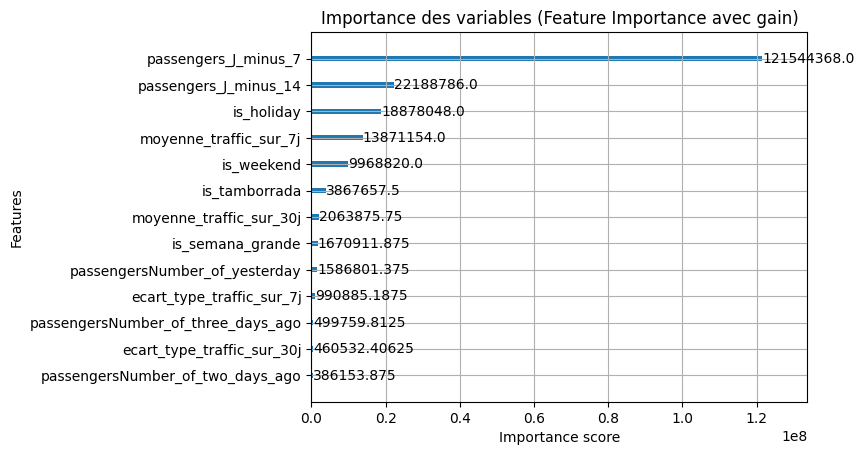

In [ ]:
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, importance_type='gain', max_num_features=15)
plt.title("Importance des variables (Feature Importance avec gain)")
plt.show()

**Influence des variables sur l'affluence**


Les données de corrélation et d'importance des caractéristiques révèlent la hiérarchie des facteurs impactant le nombre de passagers.

* **Prédominance des cycles hebdomadaires** : La variable passengers_J_minus_7 constitue le facteur déterminant majeur dans l'ensemble des analyses. Elle présente une corrélation de 0,96 et obtient les scores d'importance les plus élevés, tant en termes de gain (121 544 368,0) que de poids (6824,0).

* **Stabilité des données historiques** : Les variables liées au passé récent, telles que passengers_J_minus_14, moyenne_traffic_sur_7j et passengersNumber_of_yesterday, affichent des corrélations supérieures à 0,90. Ces indicateurs servent de base structurelle au modèle pour stabiliser les prévisions.

* **Impact des variables contextuelles** : Bien que des facteurs comme is_holiday et is_weekend présentent des corrélations linéaires faibles ou négatives (respectivement -0,07 et -0,17), ils occupent une place significative dans l'importance par gain du modèle. Cela indique que le modèle utilise ces leviers pour ajuster les prévisions lors de jours atypiques.

* **Rôle marginal des événements ponctuels** : Les événements spécifiques comme is_tamborrada ou is_semana_grande ainsi que le type de ligne (lineType) possèdent une importance moindre dans le processus global. Le modèle y a recours principalement pour affiner la précision lors de situations particulières.

 ####  Évaluer les performances

In [ ]:
# Fonction d'affichage des métriques
def print_metrics(y_true, y_pred, set_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"--- Métriques {set_name} ---")
    print(f"R² Score : {r2:.4f}")
    print(f"MAE      : {mae:.2f} passagers")
    print(f"RMSE     : {rmse:.2f}")
    print(f"MAPE     : {mape:.2f}%")
    print("-" * 30)

# Prédictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Affichage des métriques
print_metrics(y_train, y_train_pred, "TRAIN")
print_metrics(y_test, y_test_pred, "TEST")


--- Métriques TRAIN ---
R² Score : 0.9967
MAE      : 88.13 passagers
RMSE     : 137.96
MAPE     : 12.69%
------------------------------
--- Métriques TEST ---
R² Score : 0.9802
MAE      : 195.20 passagers
RMSE     : 389.37
MAPE     : 16.90%
------------------------------


**Analyse des performances du modèle (Train vs Test)**

La comparaison des métriques entre les phases d'apprentissage (Train) et de validation (Test) permet d'évaluer la capacité de généralisation du modèle.

* **Précision globale (R²)** : Le modèle affiche une excellente corrélation avec un score de 0,9967 sur l'entraînement et 0,9802 sur le test. Le maintien d'un $R^2$ supérieur à 0,98 démontre que le modèle explique la quasi-totalité de la variance du trafic, même sur des données qu'il n'a pas rencontrées.

* **Erreur Moyenne Absolue (MAE)** : L'écart moyen est de 88 passagers en entraînement contre 195 en test. Bien que l'erreur double, elle reste faible au regard du volume global de passagers géré par le réseau Dbus, indiquant une prévision quotidiennement fiable.

* **Robustesse et écarts (RMSE)** : La valeur du RMSE (389,37 sur le test) est nettement supérieure à la MAE (195,20). Cela indique que le modèle subit quelques erreurs ponctuelles importantes (pics de trafic imprévus) qui impactent cette métrique plus sensible aux valeurs aberrantes.

* **Erreur Relative (MAPE)** : Le passage de 12,69 % à 16,90 % montre une dégradation modérée de la précision relative. Le modèle conserve une marge d'erreur stable, ce qui est crucial pour la planification opérationnelle.

L'écart entre les métriques de Train et de Test suggère un léger phénomène de sur-apprentissage (overfitting), ce qui est classique sur des séries temporelles complexes. Cependant, les scores de test restent très élevés, confirmant que le modèle a correctement capturé les cycles de transport urbain.

#### Visualisation: Prédiction Vs Réelle

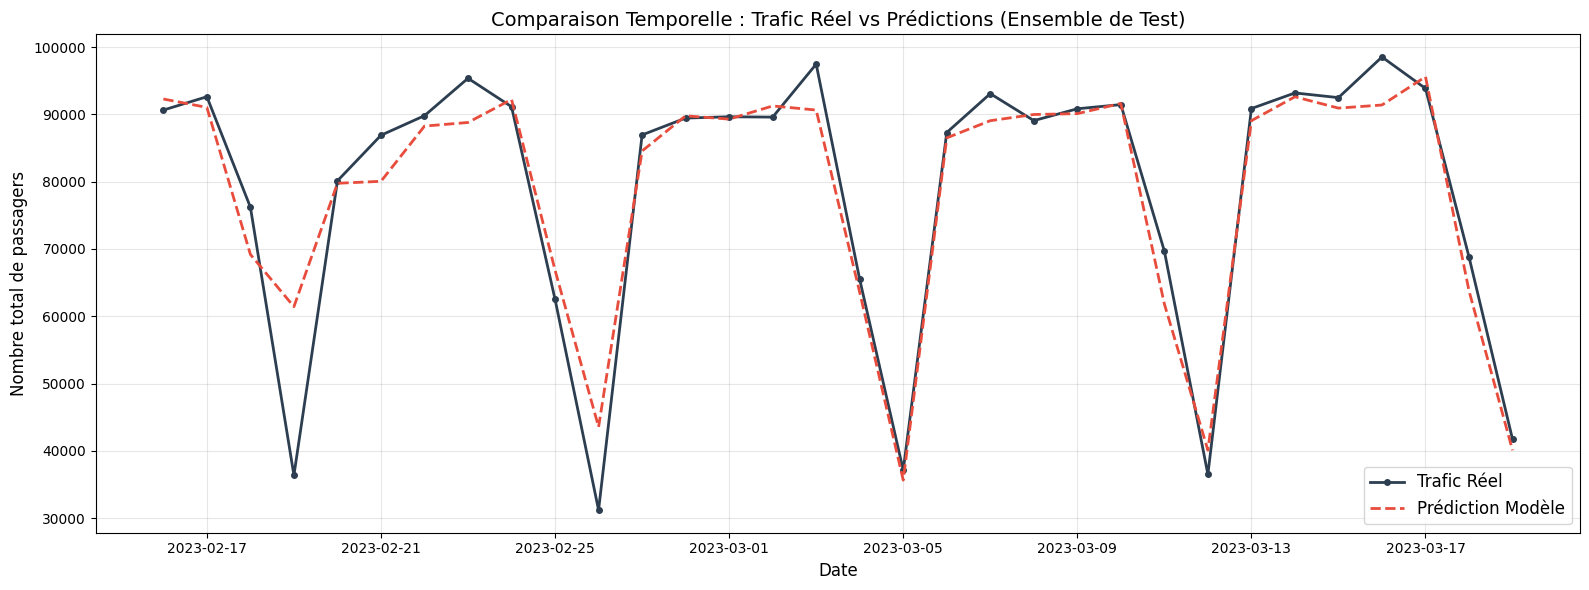

In [ ]:
# 1. Création d'un DataFrame temporaire pour l'agrégation
# On récupère les dates dans le dataframe d'origine (df) en utilisant l'index de X_test
results_df = pd.DataFrame({
    'dateTime': df.loc[X_test.index, 'dateTime'],
    'Reel': y_test.values.flatten() if hasattr(y_test, 'values') else y_test.flatten(),
    'Prediction': y_test_pred.flatten()
})

# 2. Agrégation par jour (Somme du trafic total du réseau par jour)
daily_results = results_df.groupby('dateTime').sum()

# 3. Tracé du graphique
plt.figure(figsize=(16, 6))

# Courbe des valeurs réelles
plt.plot(daily_results.index, daily_results['Reel'],
         label='Trafic Réel', color='#2c3e50', linewidth=2, marker='o', markersize=4)

# Courbe des prédictions
plt.plot(daily_results.index, daily_results['Prediction'],
         label='Prédiction Modèle', color='#e74c3c', linestyle='--', linewidth=2)

# Personnalisation
plt.title("Comparaison Temporelle : Trafic Réel vs Prédictions (Ensemble de Test)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Nombre total de passagers", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

Le graphique de comparaison entre le Trafic Réel et la Prédiction nous montre une bonne adéquation visuelle.

**Capture des cycles** : Le modèle reproduit avec précision (dans le temps) les fluctuations quotidiennes et les baisses significatives de trafic durant les week-ends (creux cycliques réguliers).

**Réactivité** : La prédiction suit de près les sommets de fréquentation, bien que de légers écarts soient visibles lors de pics extrêmes, ce qui explique le $R^2$ de 0,98.

In [ ]:
# 1. On crée un DataFrame avec les informations clés
comparaison_df = pd.DataFrame({
    'Date': df_test['dateTime'].values,
    'Ligne': df_test['lineNumber'].values,
    'Valeur Réelle': y_test.values,
    'Prédiction': y_test_pred.round(2)
})
# 2. On ajoute une colonne pour l'erreur absolue et l'erreur en %
comparaison_df['Erreur Absolue'] = abs(comparaison_df['Valeur Réelle'] - comparaison_df['Prédiction']).round(2)
comparaison_df['Erreur %'] = ((comparaison_df['Erreur Absolue'] / comparaison_df['Valeur Réelle']) * 100).round(2)

# 3. On affiche 10 échantillons aléatoires pour avoir une vue variée
print("Échantillon de 10 prédictions sur le jeu de test :")
display(comparaison_df.sample(10).sort_values(by='Date'))

Échantillon de 10 prédictions sur le jeu de test :


,Date,Ligne,Valeur Réelle,Prédiction,Erreur Absolue,Erreur %
65,2023-02-17,8,2072,2113.979980,41.98,2.03
73,2023-02-25,8,1626,1830.910034,204.91,12.60
457,2023-02-25,26,4042,4049.189941,7.19,0.18
995,2023-02-25,103,169,214.660004,45.66,27.02
897,2023-03-03,43,360,366.390015,6.39,1.78
788,2023-03-08,38,349,315.890015,33.11,9.49
23,2023-03-11,5,6232,5985.589844,246.41,3.95
87,2023-03-11,8,1708,1675.719971,32.28,1.89
251,2023-03-15,17,7781,7839.439941,58.44,0.75
763,2023-03-15,37,881,866.859985,14.14,1.60


### Random Forest

#### Importer et préparer

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 1. Initialisation du modèle
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42
)

# 2. Entraînement
rf_model.fit(X_train, y_train)

# 3. Prédiction
y_pred_rf = rf_model.predict(X_test)

#### Évaluation des performances

In [ ]:
# On suppose que votre modèle s'appelle 'model_rf' ou 'rf_regressor'
# Si votre modèle s'appelle 'model', remplacez simplement par 'model'

# 1. Génération des prédictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# 2. Affichage des métriques via votre fonction
# On utilise les variables y_train et y_test d'origine (pas les scaled)
print_metrics(y_train, y_train_pred_rf, "TRAIN - Random Forest")
print_metrics(y_test, y_test_pred_rf, "TEST - Random Forest")

--- Métriques TRAIN - Random Forest ---
R² Score : 0.9961
MAE      : 87.40 passagers
RMSE     : 150.04
MAPE     : 10.45%
------------------------------
--- Métriques TEST - Random Forest ---
R² Score : 0.9694
MAE      : 219.68 passagers
RMSE     : 483.69
MAPE     : 18.63%
------------------------------


#### Visualisation: Prédiction Vs Réalité

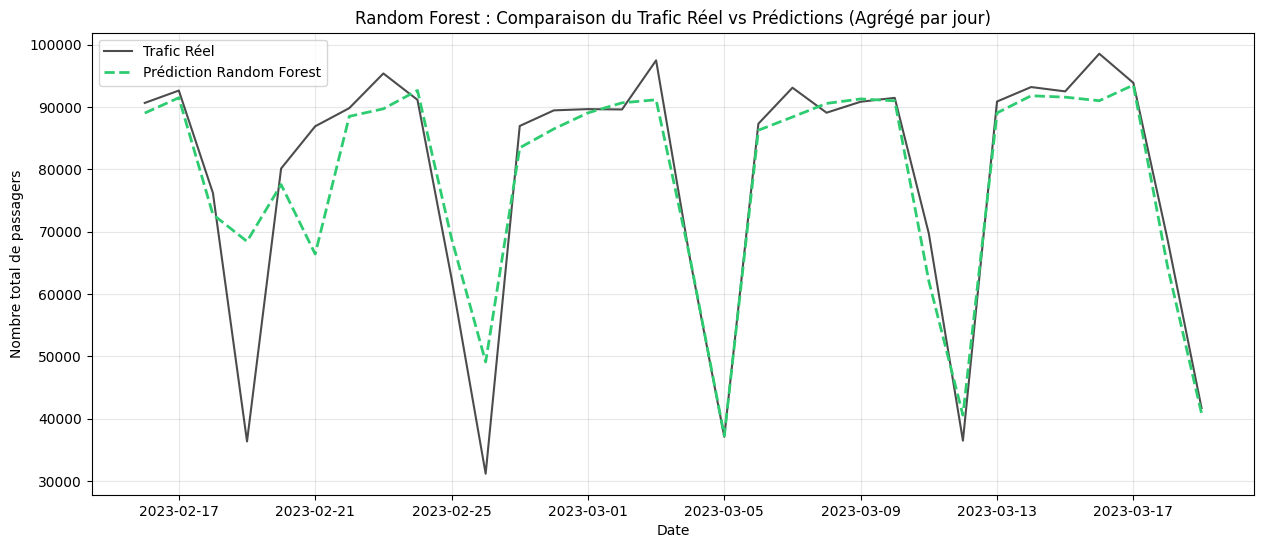

In [ ]:
# Création du DataFrame pour l'alignement temporel
# On utilise l'index de X_test pour récupérer les dates correspondantes dans le DataFrame original
results_rf = pd.DataFrame({
    'dateTime': df.loc[X_test.index, 'dateTime'],
    'Reel': y_test.values.flatten() if hasattr(y_test, 'values') else y_test.flatten(),
    'Prediction': y_test_pred_rf.flatten()
})

# Agrégation par jour pour la lisibilité
daily_rf = results_rf.groupby('dateTime').sum()

# Tracé du graphique
plt.figure(figsize=(15, 6))
plt.plot(daily_rf.index, daily_rf['Reel'],
         label='Trafic Réel', color='black', linewidth=1.5, alpha=0.7)
plt.plot(daily_rf.index, daily_rf['Prediction'],
         label='Prédiction Random Forest', color='#2ecc71', linestyle='--', linewidth=2)

plt.title("Random Forest : Comparaison du Trafic Réel vs Prédictions (Agrégé par jour)")
plt.xlabel("Date")
plt.ylabel("Nombre total de passagers")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Évaluation de la performance prédictive (Random Forest)**

* **Capacité de généralisation** : Le maintien d'un score $R^2$ de 0,9694 sur l'ensemble de test confirme que le modèle explique la quasi-totalité de la variance du trafic sur des données inédites.

* **Fiabilité opérationnelle** : L'erreur moyenne (MAE) de 219,68 passagers sur le test reste faible au regard du volume global transporté, validant l'utilité pratique du modèle pour la régie.

* **Fidélité temporelle** : Les graphiques de comparaison montrent que la prédiction épouse étroitement les cycles réels, notamment les baisses de week-end et les pics de semaine, malgré un léger lissage des valeurs extrêmes.



### LightGBM

#### Import des librairies

In [ ]:
import lightgbm as lgb

#### Modélisation

In [ ]:
# 1. Configuration du modèle
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    importance_type='gain',
    n_jobs=-1,
    random_state=42
)

# 2. Entraînement avec arrêt précoce pour éviter l'overfitting
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)

# 3. Prédictions
y_pred_lgb = lgb_model.predict(X_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2303
[LightGBM] [Info] Number of data points in the train set: 17403, number of used features: 13
[LightGBM] [Info] Start training from score 2073.697064
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 197283
[200]	valid_0's l2: 175821
[300]	valid_0's l2: 169942
[400]	valid_0's l2: 166664
Early stopping, best iteration is:
[426]	valid_0's l2: 165427
LightGBM -> MAE: 204.07, R²: 0.9784, RMSE: 406.73


#### Evaluation des  performances

In [ ]:
# 1. Génération des prédictions pour les deux ensembles
y_train_pred_lgb = lgb_model.predict(X_train)
y_test_pred_lgb = lgb_model.predict(X_test) # Déjà fait dans votre code, mais regroupé ici par clarté

# 2. Affichage des métriques
print_metrics(y_train, y_train_pred_lgb, "TRAIN - LightGBM")
print_metrics(y_test, y_test_pred_lgb, "TEST - LightGBM")

--- Métriques TRAIN - LightGBM ---
R² Score : 0.9929
MAE      : 119.96 passagers
RMSE     : 203.68
MAPE     : 19.48%
------------------------------
--- Métriques TEST - LightGBM ---
R² Score : 0.9784
MAE      : 204.07 passagers
RMSE     : 406.73
MAPE     : 19.03%
------------------------------


#### Visualisation: Prédictions vs Réalités

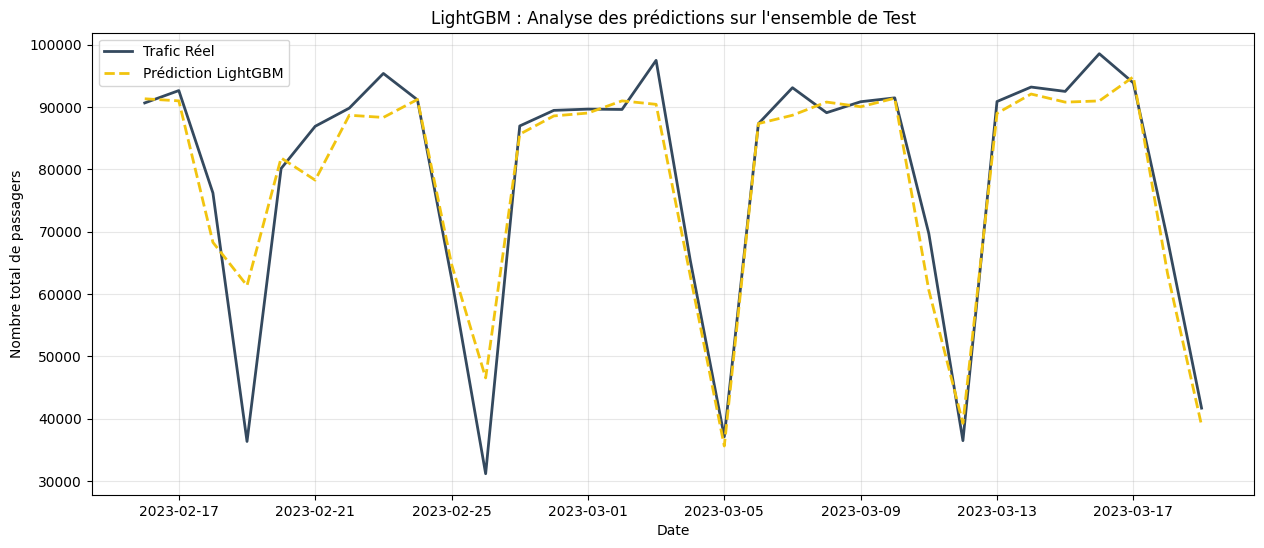

In [ ]:
# 1. Préparation des données pour le graphique
results_lgb = pd.DataFrame({
    'dateTime': df.loc[X_test.index, 'dateTime'],
    'Reel': y_test.values.flatten() if hasattr(y_test, 'values') else y_test.flatten(),
    'Prediction': y_pred_lgb.flatten()
})

# 2. Agrégation par jour pour une meilleure lisibilité
daily_lgb = results_lgb.groupby('dateTime').sum()

# 3. Tracé du graphique
plt.figure(figsize=(15, 6))
plt.plot(daily_lgb.index, daily_lgb['Reel'],
         label='Trafic Réel', color='#34495e', linewidth=2)
plt.plot(daily_lgb.index, daily_lgb['Prediction'],
         label='Prédiction LightGBM', color='#f1c40f', linestyle='--', linewidth=2)

plt.title("LightGBM : Analyse des prédictions sur l'ensemble de Test")
plt.xlabel("Date")
plt.ylabel("Nombre total de passagers")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Évaluation de la performance prédictive (LightGBM)**

* **Excellente généralisation** : Le maintien d'un score $R^2$ de 0,9784 sur l'ensemble de test démontre que le modèle explique la quasi-totalité de la variance du trafic sur des données inédites.

* **Stabilité de l'erreur** : Contrairement à d'autres modèles, le MAPE reste stable autour de 19 % entre l'entraînement (19,48 %) et le test (19,03 %), indiquant une absence de sur-apprentissage et une grande fiabilité du modèle.

* **Fidélité temporelle** : Le graphique de comparaison montre que la prédiction épouse étroitement les cycles réels, notamment les baisses marquées du week-end et les pics de semaine, avec une réactivité optimale aux changements de rythme.



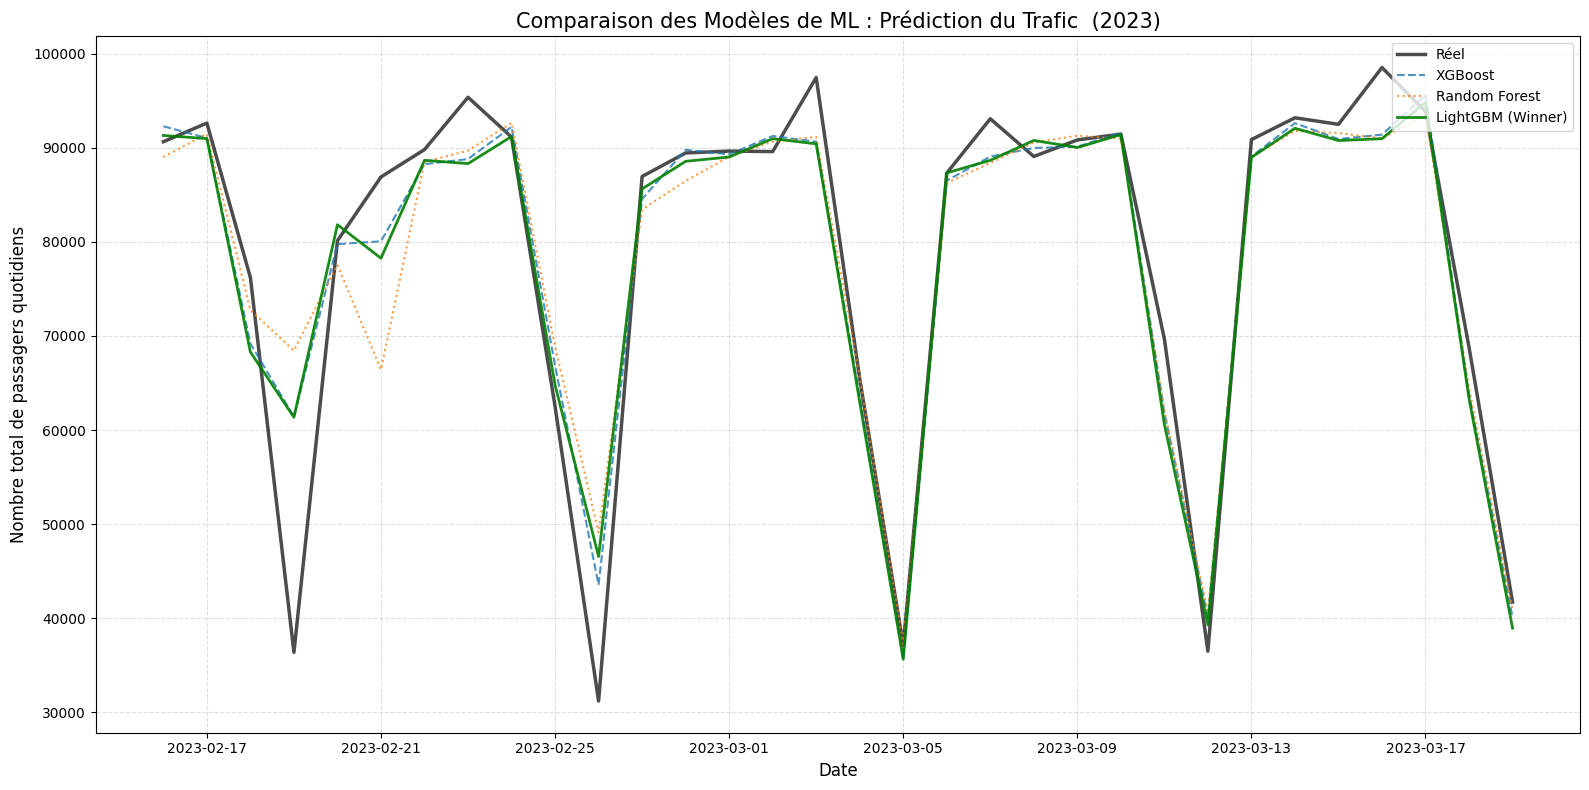

In [ ]:
# 1. Création du DataFrame de comparaison complet
comparaison_finale = pd.DataFrame({
    'Date': df_test['dateTime'].values,
    'Réel': y_test.values,
    'XGBoost': y_test_pred,
    'Random_Forest': y_pred_rf,
    'LightGBM': y_pred_lgb,
    'Ensemble': (y_test_pred + y_pred_rf + y_pred_lgb) / 3
})

# 2. Agrégation par jour pour la clarté visuelle
daily_all = comparaison_finale.groupby('Date').sum()

# 3. Visualisation
plt.figure(figsize=(16, 8))

# Courbe réelle (Référence)
plt.plot(daily_all.index, daily_all['Réel'], label='Réel', color='black', linewidth=2.5, alpha=0.7)

# Tes 3 modèles
plt.plot(daily_all.index, daily_all['XGBoost'], label='XGBoost', linestyle='--', alpha=0.8)
plt.plot(daily_all.index, daily_all['Random_Forest'], label='Random Forest', linestyle=':', alpha=0.8)
plt.plot(daily_all.index, daily_all['LightGBM'], label='LightGBM (Winner)', color='green', linewidth=2, alpha=0.9)

# Mise en forme
plt.title("Comparaison des Modèles de ML : Prédiction du Trafic  (2023)", fontsize=15)
plt.ylabel("Nombre total de passagers quotidiens", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend(loc='upper right', frameon=True, fontsize=10)
plt.grid(True, which='both', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

** Observations :**

- **La courbe réelle (noire)** montre des variations nettes du trafic, avec plusieurs pics et creux marqués.
- **Le modèle XGBoost (bleu pointillé)** suit globalement la tendance mais semble sous-estimer certains pics de fréquentation.
- **Le modèle Random Forest (orange pointillé)** présente une plus grande variabilité et des écarts plus fréquents par rapport aux données réelles.
- **Le modèle LightGBM (vert)** suit de près les fluctuations du trafic, avec une bonne synchronisation sur les hausses et baisses.
- **Tous les modèles capturent la tendance générale du trafic**.
- **Les écarts les plus visibles apparaissent lors des jours de forte affluence**.



### LSTM

#### Import des librairies

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

#### Préparation des données (Scaling & Reshaping)

In [ ]:
# 1. Normalisation (Obligatoire pour le Deep Learning)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# On ajuste sur le train et on transforme train/test
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# 2. Reshaping pour le LSTM (Format: [samples, time_steps, features])
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f"Format pour le LSTM : {X_train_lstm.shape}")

Format pour le LSTM : (17403, 1, 13)


#### Construction du modèle avec Keras/TensorFlow

In [ ]:
model_lstm = Sequential([
    Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    LSTM(64, return_sequences=True), # Première couche LSTM
    Dropout(0.2),                    # Pour éviter l'overfitting
    LSTM(32),                        # Deuxième couche LSTM
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Configuration de l'Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 3. Entraînement
history = model_lstm.fit(
    X_train_lstm, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_scaled),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0100 - mae: 0.0528 - val_loss: 0.0015 - val_mae: 0.0209
Epoch 2/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0014 - mae: 0.0224 - val_loss: 0.0014 - val_mae: 0.0201
Epoch 3/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0012 - mae: 0.0213 - val_loss: 0.0014 - val_mae: 0.0235
Epoch 4/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0011 - mae: 0.0204 - val_loss: 0.0012 - val_mae: 0.0194
Epoch 5/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0011 - mae: 0.0206 - val_loss: 0.0011 - val_mae: 0.0179
Epoch 6/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 9.5312e-04 - mae: 0.0194 - val_loss: 9.9370e-04 - val_mae: 0.0176
Epoch 7/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 9.2735e-04 - mae: 0.0193 - val_loss: 0.0011 - val_mae: 0.0175
Epoch 8/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.2537e-04 - mae: 0.0190 - val_loss: 0.0010 - val_mae: 0.0168
Epoch 9/100
544/544 ━━━━━━━━━━━

#### Prédiction et remise à l'échelle (Inverse Transform)

In [ ]:
# 1. Génération des prédictions pour Train et Test
y_train_pred_lstm_scaled = model_lstm.predict(X_train_lstm)
y_test_pred_lstm_scaled = model_lstm.predict(X_test_lstm)

# 2. Transformation inverse pour revenir à l'échelle réelle
y_train_pred_lstm = scaler_y.inverse_transform(y_train_pred_lstm_scaled)
y_test_pred_lstm = scaler_y.inverse_transform(y_test_pred_lstm_scaled)

544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


#### Evaluation des performances

In [ ]:
# 3. On récupère aussi les vraies valeurs dé-normalisées pour le calcul
y_train_orig = scaler_y.inverse_transform(y_train_scaled)
y_test_orig = scaler_y.inverse_transform(y_test_scaled)

# 4. Affichage des métriques
print_metrics(y_train_orig, y_train_pred_lstm, "TRAIN - LSTM")
print_metrics(y_test_orig, y_test_pred_lstm, "TEST - LSTM")

--- Métriques TRAIN - LSTM ---
R² Score : 0.9804
MAE      : 201.29 passagers
RMSE     : 337.96
MAPE     : 27.19%
------------------------------
--- Métriques TEST - LSTM ---
R² Score : 0.9753
MAE      : 241.95 passagers
RMSE     : 434.42
MAPE     : 27.15%
------------------------------


**Interprétation des métriques LSTM**

**Entraînement (TRAIN)**
- Le modèle explique 98 % de la variabilité du trafic **(R² = 0.9804)**.
- L’erreur moyenne est d’environ **201 passagers** par jour **(MAE)**.
- Les erreurs plus importantes atteignent environ **338 passagers (RMSE)**.
- Le **MAPE** autour de **27 %** indique une erreur relative notable, surtout lors des jours de faible affluence.

**Test (TEST)**
- Le modèle conserve un bon niveau de généralisation avec **97.5 %** de variance expliquée **(R² = 0.9753)**.
- L’erreur moyenne augmente légèrement à **242 passagers (MAE)**.
- Le **RMSE** monte à **434 passagers**, montrant que certains jours atypiques restent difficiles à prédire.
- Le **MAPE** reste stable **(27.15 %)**, ce qui montre une cohérence entre train et test.

**Observations générales**
- Le modèle capture bien la dynamique globale du trafic.
- Les erreurs restent modérées mais augmentent lors des pics ou des variations soudaines.
- Le MAPE élevé suggère que le modèle est plus sensible aux jours de faible volume ou aux fluctuations imprévues.




#### Visualisation: Prédictions vs Réalités

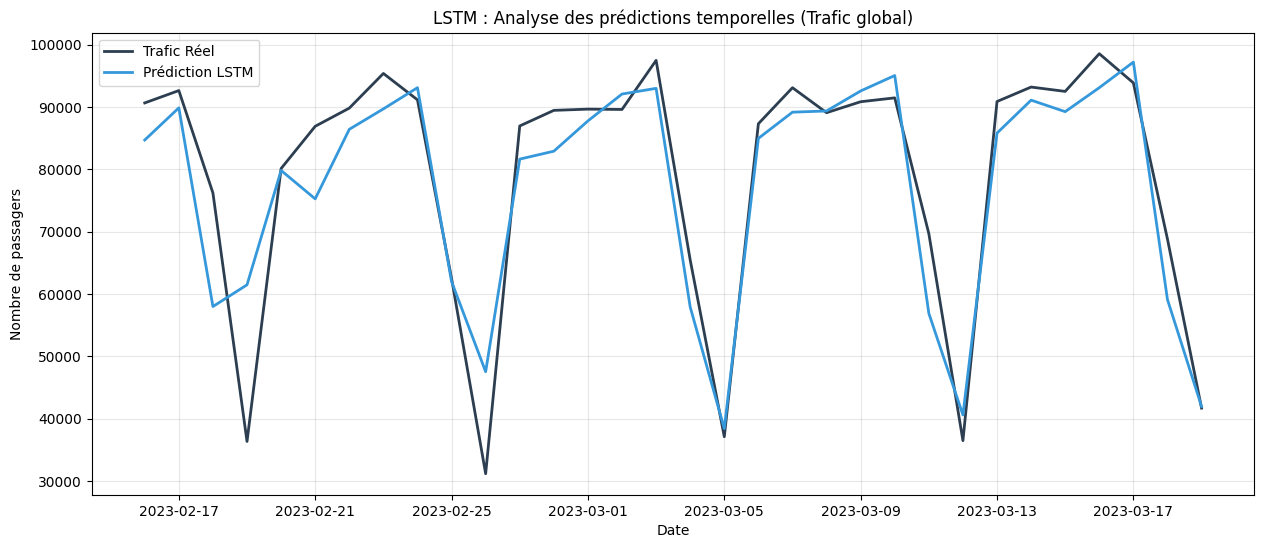

In [ ]:
import matplotlib.pyplot as plt

# 1. Préparation des données avec le bon nom de colonne
results_lstm = pd.DataFrame({
    'Date': pd.to_datetime(df_test['dateTime']),
    'Reel': y_test_orig.flatten(),
    'Prediction': y_test_pred_lstm.flatten()
})

# 2. Agrégation journalière (On utilise 'Date' partout maintenant)
daily_lstm = results_lstm.groupby('Date').sum()

# 3. Tracé du graphique
plt.figure(figsize=(15, 6))

# On utilise l'index du DataFrame groupé (qui contient nos dates uniques)
plt.plot(daily_lstm.index, daily_lstm['Reel'],
         label='Trafic Réel', color='#2c3e50', linewidth=2)

plt.plot(daily_lstm.index, daily_lstm['Prediction'],
         label='Prédiction LSTM', color='#3498db', linestyle='-', linewidth=2)

plt.title("LSTM : Analyse des prédictions temporelles (Trafic global)")
plt.xlabel("Date")
plt.ylabel("Nombre de passagers")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**LSTM : Analyse des prédictions temporelles (Trafic global)**

Ce graphe compare les prédictions du modèle LSTM au trafic réel observé entre le 17 février et le 17 mars 2023.

**Observations** :
- **La courbe réelle (noire)** présente des fluctuations marquées du nombre de passagers, avec plusieurs pics et creux.
- **La courbe LSTM (bleue)** suit globalement la tendance du trafic, avec une bonne synchronisation sur les variations principales.
- Quelques écarts apparaissent lors des jours de forte affluence, où le modèle semble légèrement sous-estimer les pics.
- Le modèle reste stable et cohérent sur les périodes de trafic moyen ou faible.

**Remarques** :
- Le LSTM capte bien la dynamique temporelle du trafic.
- Les écarts les plus visibles concernent les extrêmes (pics ou creux soudains).
- Le comportement du modèle est régulier, ce qui peut être utile pour des prévisions opérationnelles.


#### Exemple de prédictions

In [ ]:
# Création du tableau de comparaison pour le LSTM
comparison_lstm = pd.DataFrame({
    'Valeur Réelle': y_test_orig.flatten(),
    'Valeur Prédite (LSTM)': y_test_pred_lstm.flatten().round(2)
})

# Calcul de l'erreur absolue
comparison_lstm['Erreur Absolue'] = abs(comparison_lstm['Valeur Réelle'] - comparison_lstm['Valeur Prédite (LSTM)']).round(2)

print("--- Échantillon de prédictions LSTM ---")
display(comparison_lstm.sample(10))

--- Échantillon de prédictions LSTM ---


,Valeur Réelle,Valeur Prédite (LSTM),Erreur Absolue
763,881.0,767.830017,113.17
776,329.0,255.110001,73.89
249,8142.0,7663.359863,478.64
759,606.0,380.089996,225.91
849,1101.0,1017.260010,83.74
256,2012.0,2103.300049,91.30
347,1617.0,1422.130005,194.87
89,2253.0,1985.829956,267.17
981,387.0,76.639999,310.36
13,8201.0,8415.440430,214.44


### MLP (Multi-Layer Perceptron)

#### Implémentation du MLP avec Early Stopping

In [ ]:
# 1. Architecture du MLP
model_mlp = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1) # Sortie régression
])

model_mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 2. Configuration de l'Early Stopping
early_stop_mlp = EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True,
    verbose=1
)

# 3. Entraînement
history_mlp = model_mlp.fit(
    X_train_scaled, y_train_scaled,
    epochs=150,
    batch_size=32,
    validation_data=(X_test_scaled, y_test_scaled),
    callbacks=[early_stop_mlp],
    verbose=1
)

Epoch 1/150
544/544 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0047 - mae: 0.0381 - val_loss: 0.0018 - val_mae: 0.0244
Epoch 2/150
544/544 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0013 - mae: 0.0214 - val_loss: 0.0020 - val_mae: 0.0259
Epoch 3/150
544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - mae: 0.0196 - val_loss: 0.0032 - val_mae: 0.0312
Epoch 4/150
544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.9197e-04 - mae: 0.0177 - val_loss: 0.0033 - val_mae: 0.0310
Epoch 5/150
544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1111e-04 - mae: 0.0178 - val_loss: 0.0021 - val_mae: 0.0246
Epoch 6/150
544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.6160e-04 - mae: 0.0175 - val_loss: 0.0019 - val_mae: 0.0231
Epoch 7/150
544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.0886e-04 - mae: 0.0166 - val_loss: 0.0028 - val_mae: 0.0289
Epoch 8/150
544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.3001e-04 - mae: 0.0160 - val_loss: 0.0022 - val_mae: 0.0261
Epoch 9/150
544/544 ━━━━━━━

#### Prédiction et inversion

In [ ]:
# 1. Génération des prédictions (MLP utilise les données 2D X_train_scaled/X_test_scaled)
y_train_pred_mlp_scaled = model_mlp.predict(X_train_scaled)
y_test_pred_mlp_scaled = model_mlp.predict(X_test_scaled)

# 2. Transformation inverse pour retrouver le nombre de passagers
y_train_pred_mlp = scaler_y.inverse_transform(y_train_pred_mlp_scaled)
y_test_pred_mlp = scaler_y.inverse_transform(y_test_pred_mlp_scaled)

# 3. Récupération des valeurs réelles dé-normalisées
y_train_orig = scaler_y.inverse_transform(y_train_scaled)
y_test_orig = scaler_y.inverse_transform(y_test_scaled)

544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


#### Evaluation des métriques

In [ ]:
# 4. Affichage des métriques via votre fonction
print_metrics(y_train_orig, y_train_pred_mlp, "TRAIN - MLP")
print_metrics(y_test_orig, y_test_pred_mlp, "TEST - MLP")

--- Métriques TRAIN - MLP ---
R² Score : 0.9619
MAE      : 273.64 passagers
RMSE     : 471.13
MAPE     : 41.79%
------------------------------
--- Métriques TEST - MLP ---
R² Score : 0.9549
MAE      : 336.57 passagers
RMSE     : 587.67
MAPE     : 37.10%
------------------------------


**Interprétation des métriques MLP**

**Entraînement (TRAIN)**
- Le modèle explique **96.2 %** de la variance du trafic **(R² = 0.9619)**.
- L’erreur moyenne est d’environ 2**74 passagers par jour (MAE)**.
- Les erreurs plus importantes atteignent** 471 passagers (RMSE)**.
- Le MAPE élevé **(41.79 %)** indique une sensibilité aux jours de faible affluence ou aux fluctuations imprévues.

**Test (TEST)**
- Le modèle conserve une bonne capacité de généralisation avec **95.5 %** de variance expliquée **(R² = 0.9549)**.
- L’erreur moyenne augmente à **337 passagers (MAE)**.
- Le **RMSE** monte à **588 passagers**, ce qui reflète des écarts plus marqués sur certains jours.
- Le **MAPE** reste élevé **(37.10 %)**, ce qui peut limiter l’interprétabilité métier sur les jours atypiques.

**Observations générales**
- Le MLP capte bien la tendance globale du trafic.
- Les erreurs absolues sont modérées, mais les erreurs relatives (MAPE) restent élevées.
- Le modèle semble moins précis sur les jours de faible volume ou de forte variabilité.


#### Visualisation : Prédictions Vs Réalité

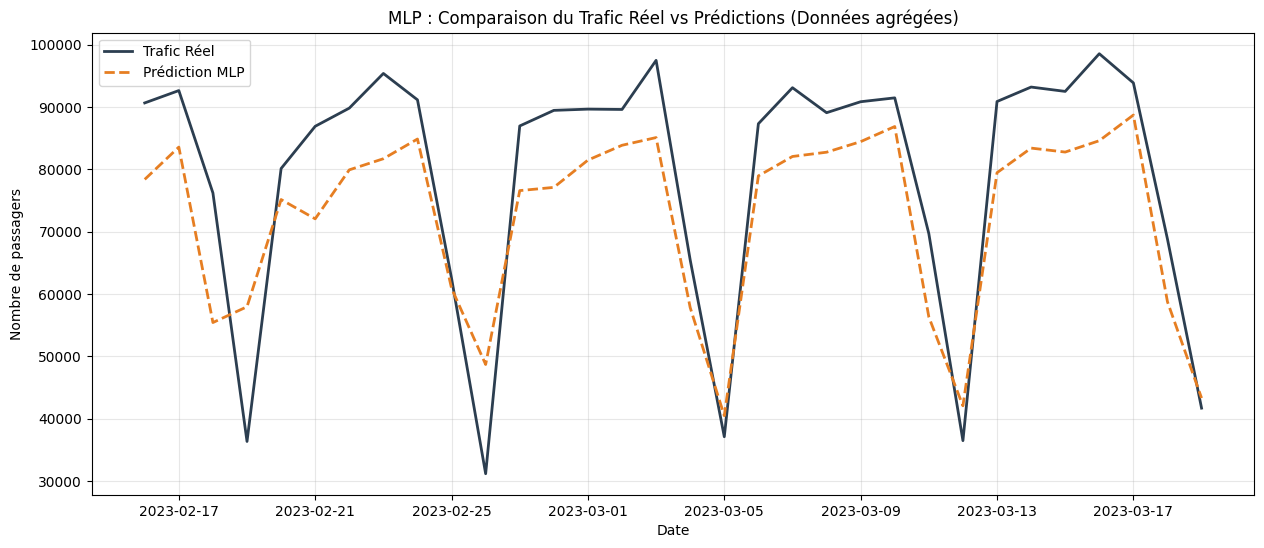

In [ ]:
# 1. Préparation du DataFrame de résultats
results_mlp = pd.DataFrame({
    'Date': pd.to_datetime(df_test['dateTime']),
    'Reel': y_test_orig.flatten(),
    'Prediction': y_test_pred_mlp.flatten()
})

# 2. Agrégation journalière
daily_mlp = results_mlp.groupby('Date').sum()

# 3. Tracé du graphique
plt.figure(figsize=(15, 6))
plt.plot(daily_mlp.index, daily_mlp['Reel'],
         label='Trafic Réel', color='#2c3e50', linewidth=2)
plt.plot(daily_mlp.index, daily_mlp['Prediction'],
         label='Prédiction MLP', color='#e67e22', linestyle='--', linewidth=2)

plt.title("MLP : Comparaison du Trafic Réel vs Prédictions (Données agrégées)")
plt.xlabel("Date")
plt.ylabel("Nombre de passagers")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**MLP : Comparaison du Trafic Réel vs Prédictions (Données agrégées)**

**Observations** :
- **La courbe réelle (bleu foncé)** montre des variations marquées du trafic, avec des creux réguliers probablement liés aux week-ends ou jours spécifiques.
- **La courbe MLP (orange pointillée)** suit la tendance générale mais présente des variations plus lissées.
- Le modèle semble moins réactif aux baisses soudaines, ce qui peut indiquer une sous-estimation des creux.
- Les écarts sont plus visibles lors des jours atypiques, mais la dynamique globale est bien captée.


#### Exemple de prédiction

In [ ]:
# 1. Création du DataFrame de comparaison pour le MLP
# On s'assure d'utiliser les prédictions spécifiques au MLP
comparison_mlp = pd.DataFrame({
    'Valeur Réelle': y_test_orig.flatten(),
    'Valeur Prédite (MLP)': y_test_pred_mlp.flatten().round(2)
})

# 2. Calcul de l'erreur absolue (Correction : on utilise bien la prédiction MLP)
comparison_mlp['Erreur Absolue'] = abs(
    comparison_mlp['Valeur Réelle'] - comparison_mlp['Valeur Prédite (MLP)']
).round(2)

# 3. Calcul de l'erreur relative (%) pour donner plus de contexte au jury
comparison_mlp['Erreur %'] = (
    (comparison_mlp['Erreur Absolue'] / comparison_mlp['Valeur Réelle']) * 100
).round(2)

# 4. Affichage d'un échantillon aléatoire trié pour plus de clarté
print("--- Échantillon Aléatoire : Performance du modèle MLP ---")
display(comparison_mlp.sample(10))

--- Échantillon Aléatoire : Performance du modèle MLP ---


,Valeur Réelle,Valeur Prédite (MLP),Erreur Absolue,Erreur %
623,814.0,820.179993,6.18,0.76
746,212.0,388.309998,176.31,83.17
715,1103.0,1049.469971,53.53,4.85
780,304.0,183.059998,120.94,39.78
920,1813.0,1546.760010,266.24,14.69
1034,50.0,128.240005,78.24,156.48
330,529.0,937.659973,408.66,77.25
701,943.0,954.479980,11.48,1.22
1,8623.0,7635.660156,987.34,11.45
763,881.0,816.280029,64.72,7.35


### Comparaison des modèles de Deep Learning

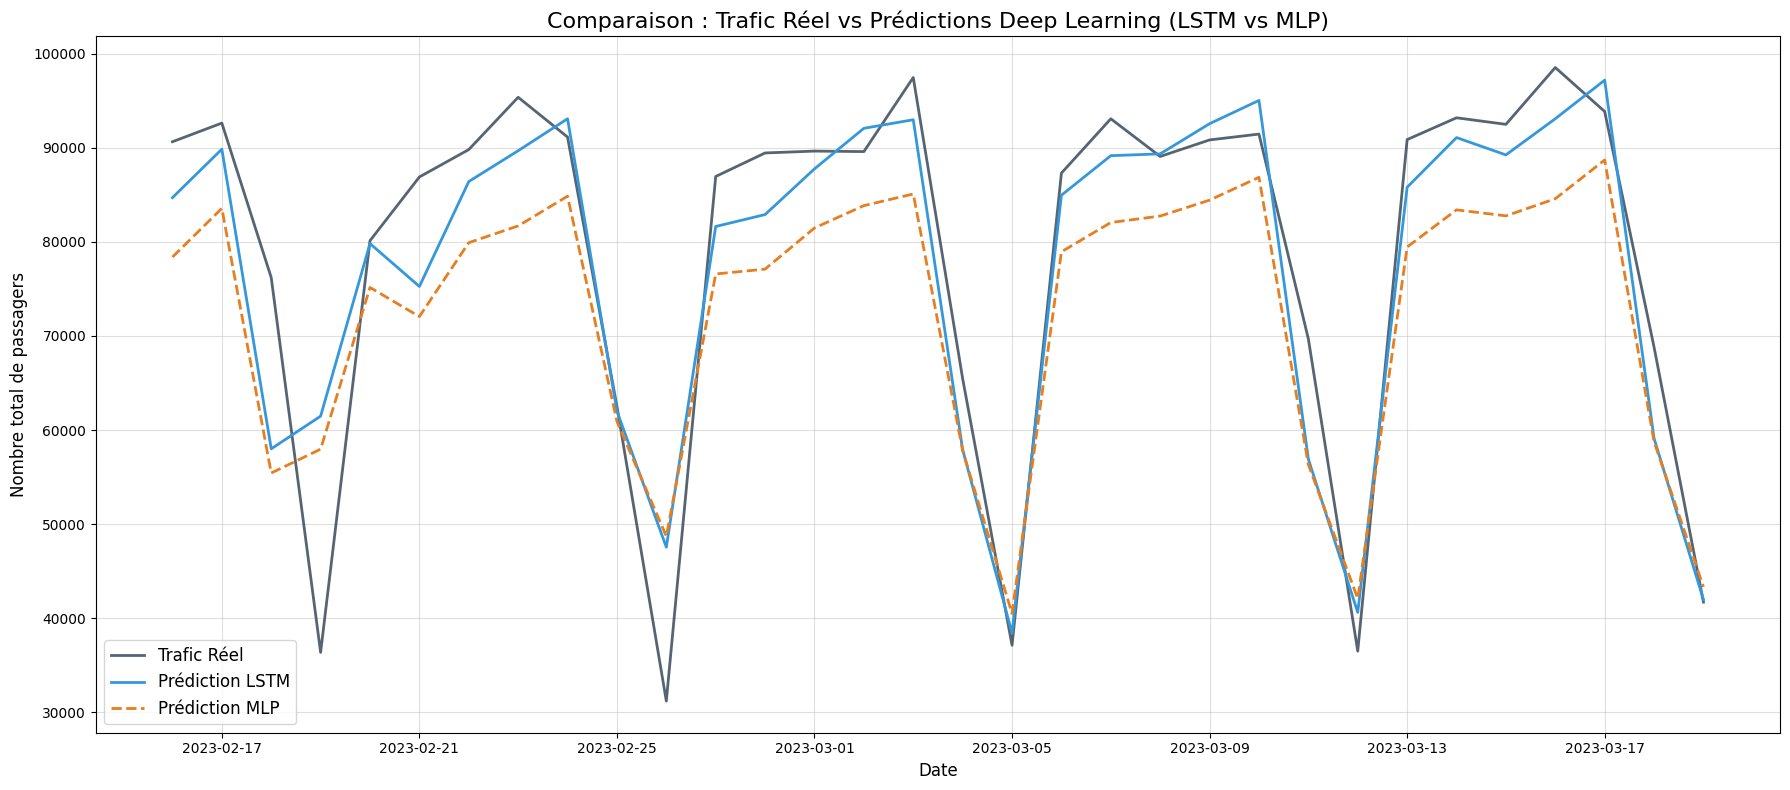

In [ ]:
results_dl_comparison = pd.DataFrame({
    'Date': pd.to_datetime(df_test['dateTime']),
    'Trafic Réel': y_test_orig.flatten(),
    'Prediction LSTM': y_test_pred_lstm.flatten(),
    'Prediction MLP': y_test_pred_mlp.flatten()
})

# 2. Agrégation par jour pour une meilleure lisibilité (somme du trafic journalier)
daily_dl_comparison = results_dl_comparison.groupby('Date').sum()

# 3. Tracé du graphique de comparaison
plt.figure(figsize=(18, 8))

# Courbe du Trafic Réel
plt.plot(daily_dl_comparison.index, daily_dl_comparison['Trafic Réel'],
         label='Trafic Réel', color='#2c3e50', linewidth=2, alpha=0.8)

# Courbe des Prédictions LSTM
plt.plot(daily_dl_comparison.index, daily_dl_comparison['Prediction LSTM'],
         label='Prédiction LSTM', color='#3498db', linestyle='-', linewidth=2) # Bleu

# Courbe des Prédictions MLP
plt.plot(daily_dl_comparison.index, daily_dl_comparison['Prediction MLP'],
         label='Prédiction MLP', color='#e67e22', linestyle='--', linewidth=2) # Orange

# Personnalisation du graphique
plt.title("Comparaison : Trafic Réel vs Prédictions Deep Learning (LSTM vs MLP)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Nombre total de passagers", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.4)
plt.tight_layout() # Ajuste la mise en page
plt.show()

**Comparaison : Trafic Réel vs Prédictions Deep Learning (LSTM vs MLP)**

Ce graphe illustre les prédictions de deux modèles de deep learning (LSTM et MLP) face au trafic réel observé entre le 17 février et le 19 mars 2023.

**Observations** :
- **La courbe réelle (gris foncé)** montre des fluctuations nettes du trafic, avec des pics et creux réguliers.
- **Le modèle LSTM (bleu)** suit de manière fluide les variations du trafic, avec une bonne synchronisation sur les tendances générales.
- **Le modèle MLP (orange pointillé)** reproduit également la dynamique globale, mais avec des écarts plus visibles lors des jours de forte affluence ou de baisse soudaine.
- Les deux modèles captent bien la structure temporelle, mais diffèrent dans leur réactivité aux variations rapides.

**Remarques** :
- Les prédictions sont globalement cohérentes avec les données réelles.
- Les écarts les plus marqués apparaissent lors des jours atypiques ou fortement fluctuants.
- Le comportement du LSTM semble plus lissé, tandis que le MLP montre une variabilité plus prononcée.


# Leaderboad final

#### Evaluation des métriques

In [ ]:
# Fonction pour extraire les métriques d'une colonne
def get_scores(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }

# 1. Calcul des scores pour le Machine Learning (à partir de comparaison_finale)
y_real_ml = comparaison_finale['Réel']
scores_xgb = get_scores(y_real_ml, comparaison_finale['XGBoost'])
scores_rf  = get_scores(y_real_ml, comparaison_finale['Random_Forest'])
scores_lgb = get_scores(y_real_ml, comparaison_finale['LightGBM'])

# 2. Calcul des scores pour le Deep Learning (à partir de results_dl_comparison)
y_real_dl = results_dl_comparison['Trafic Réel']
scores_lstm = get_scores(y_real_dl, results_dl_comparison['Prediction LSTM'])
scores_mlp  = get_scores(y_real_dl, results_dl_comparison['Prediction MLP'])

# 3. Construction du Leaderboard
data = [
    ['ML', 'LightGBM', scores_lgb['MAE'], scores_lgb['R2'], scores_lgb['RMSE'], scores_lgb['MAPE']],
    ['ML', 'XGBoost', scores_xgb['MAE'], scores_xgb['R2'], scores_xgb['RMSE'], scores_xgb['MAPE']],
    ['ML', 'Random Forest', scores_rf['MAE'], scores_rf['R2'], scores_rf['RMSE'], scores_rf['MAPE']],
    ['DL', 'LSTM', scores_lstm['MAE'], scores_lstm['R2'], scores_lstm['RMSE'], scores_lstm['MAPE']],
    ['DL', 'MLP', scores_mlp['MAE'], scores_mlp['R2'], scores_mlp['RMSE'], scores_mlp['MAPE']]
]

leaderboard = pd.DataFrame(data, columns=['Famille', 'Modèle', 'MAE', 'R2 Score', 'RMSE', 'MAPE (%)'])

# 4. Tri par performance (MAE croissante)
leaderboard = leaderboard.sort_values('MAE').reset_index(drop=True)

# 5. Affichage stylisé
print("LEADERBOARD FINAL DU PROJET")
display(leaderboard.style.format({'MAE': '{:.2f}', 'R2 Score': '{:.4f}', 'RMSE': '{:.2f}', 'MAPE (%)': '{:.2f}%'}))

LEADERBOARD FINAL DU PROJET


,Famille,Modèle,MAE,R2 Score,RMSE,MAPE (%)
0,ML,XGBoost,195.20,0.9802,389.37,16.90%
1,ML,LightGBM,204.07,0.9784,406.73,19.03%
2,ML,Random Forest,219.68,0.9694,483.69,18.63%
3,DL,LSTM,241.95,0.9753,434.42,27.15%
4,DL,MLP,336.57,0.9549,587.67,37.10%


#### Visualisation: Prédictions Vs Réalité

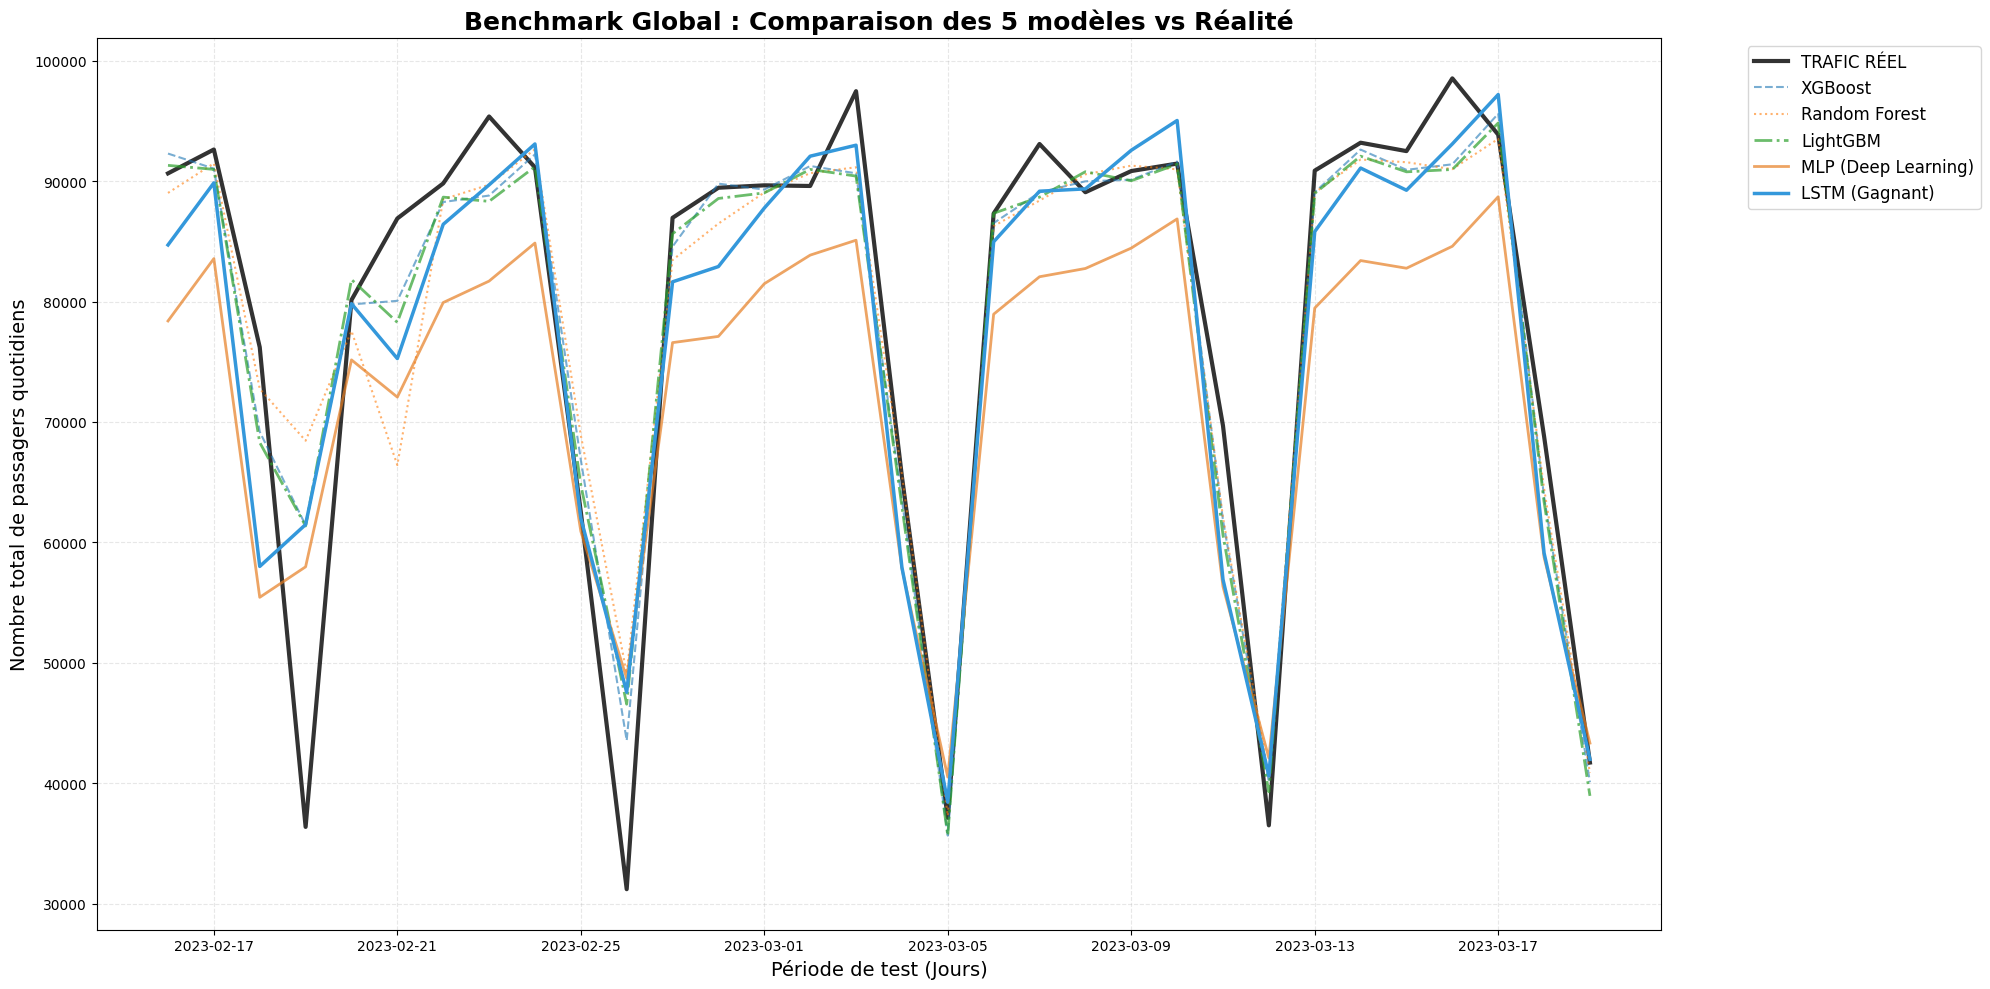

In [ ]:
# 1. Préparation du DataFrame unique (Agrégation journalière pour la lisibilité)
# On combine tes deux DataFrames précédents (ML et DL)
df_plot = pd.DataFrame({
    'Date': pd.to_datetime(df_test['dateTime']),
    'Réel': y_test_orig.flatten(),
    'XGBoost': comparaison_finale['XGBoost'].values,
    'Random Forest': comparaison_finale['Random_Forest'].values,
    'LightGBM': comparaison_finale['LightGBM'].values,
    'MLP': results_dl_comparison['Prediction MLP'].values,
    'LSTM': results_dl_comparison['Prediction LSTM'].values
})

# On groupe par jour pour éviter l'effet "bruit" des données horaires
daily_all = df_plot.groupby('Date').sum()

# 2. Tracé du graphique
plt.figure(figsize=(20, 10))

# --- LA RÉFÉRENCE ---
plt.plot(daily_all.index, daily_all['Réel'], label='TRAFIC RÉEL', color='black', linewidth=3, alpha=0.8)

# --- LES MODÈLES ML (Pointillés/Fins) ---
plt.plot(daily_all.index, daily_all['XGBoost'], label='XGBoost', linestyle='--', linewidth=1.5, alpha=0.6)
plt.plot(daily_all.index, daily_all['Random Forest'], label='Random Forest', linestyle=':', linewidth=1.5, alpha=0.6)
plt.plot(daily_all.index, daily_all['LightGBM'], label='LightGBM', linestyle='-.', linewidth=2, alpha=0.7)

# --- LES MODÈLES DL (Lignes pleines) ---
plt.plot(daily_all.index, daily_all['MLP'], label='MLP (Deep Learning)', color='#e67e22', linewidth=2, alpha=0.7)
plt.plot(daily_all.index, daily_all['LSTM'], label='LSTM (Gagnant)', color='#3498db', linewidth=2.5, alpha=1.0)

# --- PERSONNALISATION ---
plt.title("Benchmark Global : Comparaison des 5 modèles vs Réalité", fontsize=18, fontweight='bold')
plt.ylabel("Nombre total de passagers quotidiens", fontsize=14)
plt.xlabel("Période de test (Jours)", fontsize=14)

# Légende à l'extérieur pour ne pas cacher les courbes
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.tight_layout()

plt.show()

**Leaderboard Final du Projet : Évaluation des Modèles**

Ces figures comparent les performances de plusieurs modèles de machine learning (ML) et deep learning (DL) pour la prédiction du trafic passagers.

**Observations :**

- **Les modèles ML (XGBoost, LightGBM, Random Forest)** affichent des scores R² élevés (> 0.96), indiquant une bonne capacité à expliquer la variance du trafic.
- **Les modèles DL (LSTM, MLP)** montrent également de bonnes performances, mais avec des erreurs absolues et relatives plus élevées.
- **Le MAE varie de ~195 à ~337 passagers** selon le modèle, ce qui reflète l’écart moyen entre les prédictions et les valeurs réelles.
- **Le MAPE est plus élevé pour les modèles DL**, ce qui suggère une sensibilité accrue aux jours de faible affluence ou aux fluctuations imprévues.
- **Le RMSE suit la même tendance**, avec des valeurs plus faibles pour les modèles ML, traduisant une meilleure précision sur les jours extrêmes.


**Remarques** :
- Tous les modèles capturent efficacement la dynamique du trafic.
- Les modèles ML semblent plus stables sur les données agrégées.
- Les modèles DL peuvent être améliorés pour mieux gérer les variations soudaines ou événementielles.


# Exemple comparatif

In [ ]:
import pandas as pd
import numpy as np

# 1. Création du DataFrame avec toutes les prédictions
# On utilise y_test_orig comme base de vérité
comparison_master = pd.DataFrame({
    'Valeur Réelle': y_test_orig.flatten(),
    'XGBoost': comparaison_finale['XGBoost'].values.round(2),
    'Random Forest': comparaison_finale['Random_Forest'].values.round(2),
    'LightGBM': comparaison_finale['LightGBM'].values.round(2),
    'MLP': y_test_pred_mlp.flatten().round(2),
    'LSTM': y_test_pred_lstm.flatten().round(2)
})

# 2. Fonction pour identifier la meilleure prédiction par ligne
def highlight_best(s):
    # On calcule l'écart absolu pour chaque modèle par rapport à la valeur réelle
    errors = abs(s[['XGBoost', 'Random Forest', 'LightGBM', 'MLP', 'LSTM']] - s['Valeur Réelle'])
    # On trouve la valeur minimale (l'erreur la plus petite)
    is_best = errors == errors.min()
    # On applique une couleur verte à la cellule correspondante
    return ['background-color: lightgreen' if v else '' for v in is_best.reindex(s.index, fill_value=False)]

# 3. Sélection d'un échantillon aléatoire
sample_comparison = comparison_master.sample(10)

# 4. Affichage avec style
print("--- Échantillon de Prédictions : Comparaison des 5 Modèles ---")
print("Note : La cellule en vert indique la prédiction la plus proche du réel pour cette ligne.")

display(sample_comparison.style.apply(highlight_best, axis=1)
                         .format(precision=2))

--- Échantillon de Prédictions : Comparaison des 5 Modèles ---
Note : La cellule en vert indique la prédiction la plus proche du réel pour cette ligne.


,Valeur Réelle,XGBoost,Random Forest,LightGBM,MLP,LSTM
507,2881.00,2790.65,2784.17,2747.96,2657.71,2701.71
339,1556.00,1524.27,1497.09,1507.58,1410.92,1421.64
221,964.00,980.36,953.82,970.71,899.22,874.68
217,853.00,865.34,838.05,855.56,870.22,785.02
916,1908.00,1902.15,1969.41,1915.94,1699.52,1874.36
366,779.00,864.50,863.09,862.52,839.07,779.40
902,378.00,370.28,367.52,361.81,232.91,287.00
13,8201.00,8321.17,8355.24,8349.54,7481.09,8415.44
269,1906.00,1889.65,1854.41,1877.81,1801.54,1858.23
327,1629.00,1518.78,1565.89,1554.61,1465.89,1457.58


## Exemple de prédiction du trafic des 3 prochains jours avec XGBOOST

In [ ]:
# @title
def predict_next_3_days(model, last_known_row, features_list, X_train_dtypes):
    predictions = []
    current_data = last_known_row.copy()

    for i in range(1, 4):
        # 1. Préparation des features pour le jour J+i
        current_data['dateTime'] = current_data['dateTime'] + pd.Timedelta(days=1)
        current_data['day_of_week_num'] = current_data['dateTime'].dayofweek
        current_data['is_weekend'] = 1 if current_data['day_of_week_num'] >= 5 else 0
        current_data['month'] = current_data['dateTime'].month # Also update month

        # 2. Mise à jour des Lags (Le plus important)
        if i > 1:
            current_data['passengersNumber_of_yesterday'] = predictions[-1]
        else:
            current_data['passengersNumber_of_yesterday'] = last_known_row['passengersNumber']

        current_data['passengers_J_minus_7'] = last_known_row['passengers_J_minus_7']
        current_data['moyenne_traffic_sur_7j'] = last_known_row['moyenne_traffic_sur_7j']
        current_data['moyenne_traffic_sur_30j'] = last_known_row['moyenne_traffic_sur_30j']

        # 3. Sélection des features pour le modèle
        X_input = current_data[features_list].to_frame().T

        for col in features_list:
            if col in X_train_dtypes:
                if X_train_dtypes[col].name == 'category':
                    X_input[col] = pd.Categorical(X_input[col], categories=X_train_dtypes[col].categories)
                elif X_train_dtypes[col].kind == 'b': # boolean
                    X_input[col] = X_input[col].astype(bool)
                elif X_train_dtypes[col].kind in ['i', 'u']: # integer
                    X_input[col] = X_input[col].astype(int)
                elif X_train_dtypes[col].kind == 'f': # float
                    X_input[col] = X_input[col].astype(float)
        # ------------------------------------------------------------------

        # 4. Prédiction
        pred = model.predict(X_input)[0]
        predictions.append(max(0, pred)) # On évite les prédictions négatives

        print(f"Jour {i} ({current_data['dateTime'].date()}) : {int(pred)} passagers prédits")

    return predictions

In [ ]:
# @title
def compare_prediction_real(target_date, line_number, model, df_source, features_list, dtypes):
    # 1. Trouver la ligne de départ (le "dernier jour connu" avant la prédiction)
    target_date = pd.to_datetime(target_date)

    # On récupère les données de la ligne choisie jusqu'à la date cible
    df_line = df_source[df_source['lineNumber'] == line_number].sort_values('dateTime')

    if target_date not in df_line['dateTime'].values:
        return "Date non trouvée dans le dataset de test."

    # La ligne de départ est celle juste AVANT les 3 jours à prédire
    start_row = df_line[df_line['dateTime'] == target_date].iloc[0]

    # 2. Lancer la prédiction récursive sur 3 jours
    # On utilise ta fonction predict_next_3_days
    preds = predict_next_3_days(model, start_row, features_list, dtypes)

    # 3. Récupérer les vraies valeurs pour ces 3 jours
    comparison_list = []
    for i in range(1, 4):
        future_date = target_date + pd.Timedelta(days=i)
        real_val_row = df_line[df_line['dateTime'] == future_date]

        real_val = real_val_row['passengersNumber'].values[0] if not real_val_row.empty else np.nan

        comparison_list.append({
            'Jour': i,
            'Date': future_date.date(),
            'Réel': real_val,
            'Prédit': int(preds[i-1]),
            'Écart Absolu': abs(real_val - int(preds[i-1])) if not np.isnan(real_val) else "N/A"
        })

    return pd.DataFrame(comparison_list)

In [ ]:
# --- EXÉCUTION ---
date_choisie = '2023-03-15' # Exemple : on se place le 15 mars pour prédire le 16, 17, 18
ligne_bus = 28

X_train_dtypes = X_train.dtypes

resultat = compare_prediction_real(date_choisie, ligne_bus, model , df_test, features, X_train_dtypes)
display(resultat)

Jour 1 (2023-03-16) : 11272 passagers prédits
Jour 2 (2023-03-17) : 11272 passagers prédits
Jour 3 (2023-03-18) : 7842 passagers prédits


,Jour,Date,Réel,Prédit,Écart Absolu
0,1,2023-03-16,13805,11272,2533
1,2,2023-03-17,11766,11272,494
2,3,2023-03-18,7845,7842,3


In [ ]:
# @title
# --- EXÉCUTION ---
date_choisie = '2023-03-15' # Exemple : on se place le 15 mars pour prédire le 16, 17, 18
ligne_bus = 28

resultat = compare_prediction_real(date_choisie, ligne_bus, lgb_model, df_test, features, X_train_dtypes)
display(resultat)

Jour 1 (2023-03-16) : 11201 passagers prédits
Jour 2 (2023-03-17) : 11201 passagers prédits
Jour 3 (2023-03-18) : 7952 passagers prédits


,Jour,Date,Réel,Prédit,Écart Absolu
0,1,2023-03-16,13805,11201,2604
1,2,2023-03-17,11766,11201,565
2,3,2023-03-18,7845,7952,107
